In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
usuarios = pd.read_csv('/content/drive/My Drive/TFM/Linea1-Usuarios.txt', sep=";", encoding="ISO-8859-1")
consumos = pd.read_csv('/content/drive/My Drive/TFM/Linea1-Consumos.txt', sep=";", encoding="ISO-8859-1")
sesiones = pd.read_csv('/content/drive/My Drive/TFM/Linea1-Sesiones.txt', sep=";", encoding="ISO-8859-1")
ventas = pd.read_csv('/content/drive/My Drive/TFM/Linea1-Ventas.txt', sep=";", encoding="ISO-8859-1")

In [ ]:
usuarios.head()

,IDUSUARIO,TIPOUSUARIO,FEC_REGISTRO,CANAL_REGISTRO,IND_CLIENTE,TIPOEMAIL,BONDAD_EMAIL,USU_TIPO,USU_TAMANIO,USU_CIIU,USU_ESTADO,USU_DEPARTAMENTO,FEC_CLIENTE
0,"7668403,00",PF,14/3/2019 0:00:00,3.0,0,gmail.com,20,NaN,NaN,NaN,NaN,NaN,NaN
1,"7667922,00",PF,14/3/2019 0:00:00,2.0,0,hotmail.com,20,NaN,NaN,NaN,NaN,NaN,NaN
2,"7721206,00",PJ,10/4/2019 0:00:00,4.0,0,ilc.com.co,20,NaN,NaN,NaN,NaN,CALDAS,NaN
3,"7667953,00",PJ,14/3/2019 0:00:00,3.0,0,gmail.com,20,EMPRESARIO INDIVIDUAL,MC,M7110,ACTIVA,BOGOTA,NaN
4,"7667971,00",PJ,14/3/2019 0:00:00,3.0,0,acadia.com.co,20,SOCIEDAD COMERCIAL/INDUSTRIAL,PQ,L6810,ACTIVA,BOGOTA,NaN


In [ ]:
usuarios['USU_TIPO'].value_counts()

SOCIEDAD COMERCIAL/INDUSTRIAL      16021
EMPRESARIO INDIVIDUAL              14635
ENTIDAD FINANCIERA O DE SEGUROS     1063
ENTIDAD SIN ANIMO DE LUCRO          1011
ORGANISMO ESTATAL                    262
HOLDING                              177
ENTIDAD EXTRANJERA                   132
SOCIEDAD NO COMERCIAL                  5
INDUSTRIA / COMERCIO                   2
Name: USU_TIPO, dtype: int64

# Tabla USUARIOS

In [ ]:
# Primero vamos a revisar cuantos clientes y no clientes tenemos:
print(len(usuarios[usuarios['IND_CLIENTE']==1]))
print(len(usuarios[usuarios['IND_CLIENTE']==0]))

2615
140121


Vemos que el dataset está muy desbalanceado ya que solo disponemos de 2615 clientes del total de 142.736

## Variable IDUSUARIO

In [ ]:
# Comenzamos con la variable IDUSUARIO dandole el formato deseado:
# Dividimos la columa IDUSUARIO por ','
usuarios[['ID_USUARIO', 'COMA']] = usuarios.IDUSUARIO.str.split(",", expand=True,)
# Eliminamos las columnas que no nos interesan
usuarios = usuarios.drop(columns = ['COMA', 'IDUSUARIO'])

In [ ]:
# Miramos si existen repetidos 
print(len(usuarios['ID_USUARIO']))
import numpy as np
print(len(np.unique(usuarios['ID_USUARIO'])))

142736
142736


Confirmamos que no existen repetidos.

##Variable TIPOUSUARIO

In [ ]:
# Para la variable TIPOUSUARIO, vemos que existe una categoría PX que no se sabe a ciencia cierta si pertenece
# a una categoria o a otra, revisamos cuanto supone del total.
(len(usuarios[usuarios['TIPOUSUARIO']=='PX'])/len(usuarios['TIPOUSUARIO']))*100

3.4553301199417104

In [ ]:
# Solo supone un 3.46% de los datos, vamos a revisar cuanto supondría respecto a la variable a predecir:
usuarios[usuarios['TIPOUSUARIO']=='PX'].IND_CLIENTE.value_counts()

0    4792
1     140
Name: IND_CLIENTE, dtype: int64

In [ ]:
# Vemos que mientras para los clientes son un 5.35% si los eliminamos, para los no clientes es un 3.42%, la diferencia no es muy grande.
# Vamos a ver si al limpiar el resto de variables mantenemos las proporciones, sino volveremos a revisar esta variable.
# Por lo que, filtramos el dataset:
usuarios = usuarios[usuarios['TIPOUSUARIO']!='PX'].reset_index(drop = True)

In [ ]:
# Vamos a codificar la variable TIPOUSUARIO:
def f(row):
    if row['TIPOUSUARIO'] == 'PJ':
        val = 0 # Persona juridica
    else:
        val = 1 # Persona fisica
    return val
usuarios['TIPO_USUARIO'] = usuarios.apply(f, axis=1)

In [ ]:
# Eliminamos las columnas que no nos interesan
usuarios = usuarios.drop(columns = ['TIPOUSUARIO'])

## Variable CANAL_REGISTRO

In [ ]:
# Revisamos los datos que tenemos en la variable CANAL_REGISTRO
np.unique(usuarios['CANAL_REGISTRO'])

array([ 1.,  2.,  3.,  4.,  6.,  7.,  8.,  9., nan])

In [ ]:
# Vemos que tenemos nan, vamos a ver cuantos hay
(len(usuarios[usuarios['CANAL_REGISTRO'].isnull()])/len(usuarios['CANAL_REGISTRO']))*100

2.4796087196307797

In [ ]:
# Solo supone un 2.48% de los datos, vamos a revisar cuanto supondría respecto a la variable a predecir:
usuarios[usuarios['CANAL_REGISTRO'].isnull()].IND_CLIENTE.value_counts()

0    3399
1      18
Name: IND_CLIENTE, dtype: int64

In [ ]:
# Vemos que, con el dataset filtrado previamente, mientras para los clientes son un 0.73% si los eliminamos,
# para los no clientes es un 2.51%. Si lo comparamos con los numeros previos sin filtrar tenemos que para
# los clientes eliminamos un 6.04% de los casos al filtrar, y para los no clientes un 5.86%. Por tanto, estamos 
# manteniendo bastante bien la proporción. Por lo que, filtramos el dataset:
usuarios = usuarios[usuarios['CANAL_REGISTRO'].notnull()].reset_index(drop = True)

In [ ]:
# Vamos a codificar la variable CANAL_REGISTRO, para ello vamos a agrupar los valores:
def fu(row):
    if row['CANAL_REGISTRO'] == 1:
        val = 'SEM'
    elif row['CANAL_REGISTRO'] == 4:
        val = 'SEO'
    elif row['CANAL_REGISTRO'] in (2, 3, 7):
        val = 'DP'
    else:
        val = 'DE'
    return val

In [ ]:
usuarios['CANALREGISTRO'] = usuarios.apply(fu, axis=1)

In [ ]:
# Para codificar esta variable vamos a realizar un one hot encoding:
from sklearn.preprocessing import OneHotEncoder

# Creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

# Perform one-hot encoding on 'CANALREGISTRO' column 
encoder_df = pd.DataFrame(encoder.fit_transform(usuarios[['CANALREGISTRO']]).toarray())

# Merge one-hot encoded columns back with original DataFrame
usuarios = usuarios.join(encoder_df)

In [ ]:
# Renombramos las columnas
usuarios.columns = ['FEC_REGISTRO', 'CANAL_REGISTRO', 'IND_CLIENTE', 'TIPOEMAIL', 'BONDAD_EMAIL', 'USU_TIPO', 'USU_TAMANIO', 'USU_CIIU',
                    'USU_ESTADO', 'USU_DEPARTAMENTO', 'FEC_CLIENTE', 'ID_USUARIO', 'TIPO_USUARIO', 'CANALREGISTRO', 'DE', 'DP', 'SEM', 'SEO']

In [ ]:
# Eliminamos las columnas que no nos interesan
# Eliminamos la columna de SEO, ya que esta información se recoge con las tres anteriores (DE - DP - SEM)
usuarios = usuarios.drop(columns = ['CANAL_REGISTRO', 'CANALREGISTRO', 'SEO'])

## Variable BONDAD_EMAIL

In [ ]:
# Agrupamos la variable en función de la calidad del email
def fun(row):
    if row['BONDAD_EMAIL'] == 20:
        val = 'Verde'
    elif row['BONDAD_EMAIL'] in (1, 0, -10):
        val = 'Invalido'
    elif row['BONDAD_EMAIL'] == 9:
        val = 'Naranja'
    else:
        val = 'nulo'
    return val

In [ ]:
usuarios['BONDADEMAIL'] = usuarios.apply(fun, axis=1)

In [ ]:
# Codificar BONDADEMAIL con one hot encoding:

# Creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

# Perform one-hot encoding on 'team' column 
encoder_df = pd.DataFrame(encoder.fit_transform(usuarios[['BONDADEMAIL']]).toarray())

# Merge one-hot encoded columns back with original DataFrame
usuarios = usuarios.join(encoder_df)

In [ ]:
# Renombramos las columnas
usuarios.columns = ['FEC_REGISTRO', 'IND_CLIENTE', 'TIPOEMAIL', 'BONDAD_EMAIL', 'USU_TIPO', 'USU_TAMANIO', 'USU_CIIU',
                    'USU_ESTADO', 'USU_DEPARTAMENTO', 'FEC_CLIENTE', 'ID_USUARIO', 'TIPO_USUARIO', 'DE', 'DP', 'SEM',
                    'BONDADEMAIL', 'Invalido', 'Naranja', 'Verde', 'emailnulo']

In [ ]:
# Eliminamos las columnas que no nos interesan
# Eliminamos también la columna emailnulo, ya que esta información la almacenamos en las dos anteriores
usuarios = usuarios.drop(columns = ['BONDAD_EMAIL', 'BONDADEMAIL', 'emailnulo'])

## Variable TIPOEMAIL

In [ ]:
# Pasamos a revisar la variable TIPOEMAIL
# Entendemos que si la vaiable Naranja, Verde y Invalido es 0 la variable TIPOEMAIL deberá no estar registrada
import numpy as np
usuarios[(usuarios['Naranja']==0) & (usuarios['Verde']==0) & (usuarios['Invalido']==0)].TIPOEMAIL.value_counts()

gmail.com           1494
hotmail.com         1107
yopmail.com           90
yahoo.com             72
yahoo.es              60
                    ... 
hmsol.vpm              1
live.net               1
unab.edu.co            1
calzadovolta.com       1
betta.gp               1
Name: TIPOEMAIL, Length: 498, dtype: int64

In [ ]:
# Como vemos, tiene registros, luego entendemos que la calidad de esta variable no es la correcta y procedemos a eliminarla
usuarios = usuarios.drop(columns = ['TIPOEMAIL'])

## Variable USU_TIPO

In [ ]:
# Revisamos que guarda esta variable
np.unique(usuarios['USU_TIPO'].astype(str))

array(['EMPRESARIO INDIVIDUAL', 'ENTIDAD EXTRANJERA',
       'ENTIDAD FINANCIERA O DE SEGUROS', 'ENTIDAD SIN ANIMO DE LUCRO',
       'HOLDING', 'INDUSTRIA / COMERCIO', 'ORGANISMO ESTATAL',
       'SOCIEDAD COMERCIAL/INDUSTRIAL', 'SOCIEDAD NO COMERCIAL', 'nan'],
      dtype=object)

In [ ]:
# Si seleccionamos PF, esta variable debería dar null o EMPRESARIO INDIVIDUAL, contamos cuantos null tenemos:
usuarios[usuarios['TIPO_USUARIO']== 1].USU_TIPO.isna().sum()

99123

In [ ]:
# Revisamos el resto de valores que guarda cuando es PF
usuarios[usuarios['TIPO_USUARIO']== 1].USU_TIPO.value_counts()

EMPRESARIO INDIVIDUAL              389
ENTIDAD FINANCIERA O DE SEGUROS      9
SOCIEDAD COMERCIAL/INDUSTRIAL        2
Name: USU_TIPO, dtype: int64

In [ ]:
# Revisamos los dos casos de SOCIEDAD COMERCIAL/INDUSTRIAL
usuarios[(usuarios['TIPO_USUARIO']==1) & (usuarios['USU_TIPO']=='SOCIEDAD COMERCIAL/INDUSTRIAL')]

,FEC_REGISTRO,IND_CLIENTE,USU_TIPO,USU_TAMANIO,USU_CIIU,USU_ESTADO,USU_DEPARTAMENTO,FEC_CLIENTE,ID_USUARIO,TIPO_USUARIO,DE,DP,SEM,Invalido,Naranja,Verde
93997,18/6/2019 0:00:00,0,SOCIEDAD COMERCIAL/INDUSTRIAL,MC,Z9999,LIQUIDACION,CHOCO,NaN,7849417,1,0.0,0.0,1.0,0.0,0.0,1.0
131005,15/1/2019 0:00:00,0,SOCIEDAD COMERCIAL/INDUSTRIAL,MC,G4690,LIQUIDACION,CUNDINAMARCA,NaN,7541846,1,0.0,0.0,1.0,1.0,0.0,0.0


In [ ]:
# Eliminamos los dos registros que aparecen como SOCIEDAD COMERCIAL/INDUSTRIAL ya que entendemos que una persona física no le corresponde
# esta categoría. Ninguno de los dos casos es cliente.
usuarios = usuarios.drop(usuarios[(usuarios['TIPO_USUARIO']==1) & (usuarios['USU_TIPO']=='SOCIEDAD COMERCIAL/INDUSTRIAL')].index).reset_index(drop = True)

In [ ]:
# Revisamos los nueve casos de ENTIDAD FINANCIERA O DE SEGUROS
usuarios[(usuarios['TIPO_USUARIO']==1) & (usuarios['USU_TIPO']=='ENTIDAD FINANCIERA O DE SEGUROS')]

,FEC_REGISTRO,IND_CLIENTE,USU_TIPO,USU_TAMANIO,USU_CIIU,USU_ESTADO,USU_DEPARTAMENTO,FEC_CLIENTE,ID_USUARIO,TIPO_USUARIO,DE,DP,SEM,Invalido,Naranja,Verde
1667,2/3/2019 0:00:00,0,ENTIDAD FINANCIERA O DE SEGUROS,MC,K6621,ACTIVA,BOGOTA,NaN,7623128,1,0.0,0.0,0.0,0.0,0.0,1.0
2580,10/6/2019 0:00:00,0,ENTIDAD FINANCIERA O DE SEGUROS,MC,K6621,ACTIVA,RISARALDA,NaN,7836547,1,0.0,1.0,0.0,0.0,0.0,1.0
29994,10/12/2018 0:00:00,0,ENTIDAD FINANCIERA O DE SEGUROS,MC,K6511,ACTIVA,CESAR,NaN,7503558,1,0.0,0.0,1.0,0.0,1.0,0.0
30225,4/12/2018 0:00:00,0,ENTIDAD FINANCIERA O DE SEGUROS,MC,K6621,ACTIVA,ANTIOQUIA,NaN,7496819,1,1.0,0.0,0.0,0.0,0.0,1.0
55319,6/9/2018 0:00:00,0,ENTIDAD FINANCIERA O DE SEGUROS,MC,K6621,ACTIVA,CUNDINAMARCA,NaN,7350818,1,0.0,1.0,0.0,0.0,0.0,1.0
77108,22/8/2018 0:00:00,0,ENTIDAD FINANCIERA O DE SEGUROS,MC,K6621,ACTIVA,BOGOTA,NaN,7320822,1,0.0,1.0,0.0,1.0,0.0,0.0
86570,19/4/2018 0:00:00,0,ENTIDAD FINANCIERA O DE SEGUROS,MC,K6621,ACTIVA,CUNDINAMARCA,NaN,7072388,1,1.0,0.0,0.0,1.0,0.0,0.0
118180,7/2/2018 0:00:00,0,ENTIDAD FINANCIERA O DE SEGUROS,MC,K6615,ACTIVA,ANTIOQUIA,NaN,6919787,1,0.0,0.0,0.0,0.0,0.0,1.0
119352,25/4/2018 0:00:00,1,ENTIDAD FINANCIERA O DE SEGUROS,MC,K6621,ACTIVA,BOGOTA,25/4/2018 0:00:00,7086038,1,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
# Eliminamos los nueve registros que aparecen como ENTIDAD FINANCIERA O DE SEGUROS ya que entendemos que una persona física no le corresponde
# esta categoría. Solo un caso es cliente.
usuarios = usuarios.drop(usuarios[(usuarios['TIPO_USUARIO']==1) & (usuarios['USU_TIPO']=='ENTIDAD FINANCIERA O DE SEGUROS')].index).reset_index(drop = True)

In [ ]:
# Por el contrario, si seleccionamos PJ, esta variable no debería dar null:
usuarios[(usuarios['TIPO_USUARIO']==0)].USU_TIPO.isna().sum()

2775

In [ ]:
# Revisamos el resto de valores que guarda cuando es PJ
usuarios[usuarios['TIPO_USUARIO']==0].USU_TIPO.value_counts()

SOCIEDAD COMERCIAL/INDUSTRIAL      15601
EMPRESARIO INDIVIDUAL              13937
ENTIDAD SIN ANIMO DE LUCRO          1000
ENTIDAD FINANCIERA O DE SEGUROS      982
ORGANISMO ESTATAL                    260
HOLDING                              175
ENTIDAD EXTRANJERA                   128
SOCIEDAD NO COMERCIAL                  4
INDUSTRIA / COMERCIO                   2
Name: USU_TIPO, dtype: int64

In [ ]:
# Procedemos a eliminar los 2775 registros que siendo PJ, la variable USU_TIPO es nula:
usuarios = usuarios.drop(usuarios[(usuarios['TIPO_USUARIO']==0) & (usuarios['USU_TIPO'].isnull())].index).reset_index(drop = True)

In [ ]:
# Vamos a crear una nueva variable para agrupar las diferentes categorías de la variable USU_TIPO:
def func(row):
    if pd.isna(row['USU_TIPO']):
        val = 'nulo'
    elif row['USU_TIPO'] == 'SOCIEDAD COMERCIAL/INDUSTRIAL':
        val = 'SCI'
    elif row['USU_TIPO'] == 'EMPRESARIO INDIVIDUAL':
        val = 'EI'
    else:
        val = 'resto'
    return val

In [ ]:
usuarios['USUTIPO'] = usuarios.apply(func, axis=1)

In [ ]:
# Creamos las variables en base a USUTIPO:
def funci(row):
    if row['USUTIPO'] == 'SCI':
      val = 1
    else:
        val = 0
    return val
usuarios['USUSCI'] = usuarios.apply(funci, axis=1)

In [ ]:
def funcio(row):
    if row['USUTIPO'] == 'nulo':
      val = 1
    else:
        val = 0
    return val
usuarios['USUNulo'] = usuarios.apply(funcio, axis=1)

In [ ]:
def funcion(row):
    if row['USUTIPO'] == 'EI':
      val = 1
    else:
        val = 0
    return val
usuarios['USUEI'] = usuarios.apply(funcion, axis=1)

In [ ]:
# Procedemos a eliminar las variables que no nos interesan
usuarios = usuarios.drop(columns = ['USU_TIPO', 'USUTIPO'])

## Variable USU_TAMANIO

In [ ]:
# Revisamos que guarda esta variable
np.unique(usuarios['USU_TAMANIO'].astype(str))

array(['GR', 'MC', 'MD', 'PQ', 'SD', 'nan'], dtype=object)

In [ ]:
# Si seleccionamos PF, esta variable debería dar null o SD:
usuarios[usuarios['TIPO_USUARIO']==1].USU_TAMANIO.value_counts()

MC    344
SD     44
PQ      1
Name: USU_TAMANIO, dtype: int64

In [ ]:
# Vemos que existen Pequeñas y Micro empresas, vamos a ver cuantos clientes tenemos en estos casos:
usuarios[(usuarios['TIPO_USUARIO']== 1) & ((usuarios['USU_TAMANIO'] == ('PQ')) | (usuarios['USU_TAMANIO'] == ('MC')))].IND_CLIENTE.value_counts()

0    341
1      4
Name: IND_CLIENTE, dtype: int64

In [ ]:
# Vemos que procederiamos a enviar 341 no clientes frente a 4 clientes:
# Procedemos a eliminar los 345 registros que siendo PF, la variable USU_TAMANIO es MC o PQ:
usuarios = usuarios.drop(usuarios[(usuarios['TIPO_USUARIO']== 1) & ((usuarios['USU_TAMANIO'] == ('PQ')) | (usuarios['USU_TAMANIO'] == ('MC')))].index).reset_index(drop = True)

In [ ]:
# Para los 44 valores que hemos encontrado como SD procedemos a cambiarlos como nulos:
usuarios.loc[(usuarios['TIPO_USUARIO']== 1) & (usuarios['USU_TAMANIO'] == ('SD')), "USU_TAMANIO"] = None

In [ ]:
# Revisamos ahora si seleccionamos PJ, esta variable no debería dar null:
usuarios[usuarios['TIPO_USUARIO']== 0].USU_TAMANIO.isna().sum()

0

In [ ]:
# Creamos las variables en base a USU_TAMANIO:
def funti(row):
    if row['USU_TAMANIO'] == 'GR':
      val = 1
    else:
        val = 0
    return val
usuarios['TAM_GR'] = usuarios.apply(funti, axis=1)

In [ ]:
def funtio(row):
    if row['USU_TAMANIO'] == 'MD':
      val = 1
    else:
        val = 0
    return val
usuarios['TAM_MD'] = usuarios.apply(funtio, axis=1)

In [ ]:
def funtion(row):
    if row['USU_TAMANIO'] == 'PQ':
      val = 1
    else:
        val = 0
    return val
usuarios['TAM_PQ'] = usuarios.apply(funtion, axis=1)

In [ ]:
def f(row):
    if row['USU_TAMANIO'] == 'MC':
      val = 1
    else:
        val = 0
    return val
usuarios['TAM_MC'] = usuarios.apply(f, axis=1)

In [ ]:
def fu(row):
    if row['USU_TAMANIO'] == 'SD':
      val = 1
    else:
        val = 0
    return val
usuarios['TAM_SD'] = usuarios.apply(fu, axis=1)

In [ ]:
# Procedemos a eliminar las variables que no nos interesan
usuarios = usuarios.drop(columns = ['USU_TAMANIO'])

## Variable USU_CIIU

In [ ]:
# Si seleccionamos PF, esta variable debería dar null:
usuarios[usuarios['TIPO_USUARIO']==1].USU_CIIU.value_counts()

S9609    16
S9512     2
Z9999     2
G4711     2
G4759     2
G4761     1
Q8699     1
G4719     1
I5619     1
M7110     1
G4782     1
G4731     1
G4661     1
H4921     1
R9200     1
G4773     1
M6920     1
G4649     1
S9524     1
C1521     1
B0510     1
G4741     1
I5630     1
G4520     1
H5221     1
Name: USU_CIIU, dtype: int64

In [ ]:
# Revisamos cuantos casos hay para clientes y cuantos para no clientes
print(sum(usuarios[(usuarios['TIPO_USUARIO']== 1) & (usuarios['IND_CLIENTE'] == 0)].USU_CIIU.value_counts()))
print(sum(usuarios[(usuarios['TIPO_USUARIO']== 1) & (usuarios['IND_CLIENTE'] == 1)].USU_CIIU.value_counts()))

43
1


In [ ]:
# Por tanto procedemos a eliminar todos los registros donde siendo persona fisica esta variable no guade null
usuarios = usuarios.drop(usuarios[(usuarios['TIPO_USUARIO']== 1) & (usuarios['USU_CIIU'].notna())].index).reset_index(drop = True)

In [ ]:
# Si seleccionamos PJ, esta variable no debería dar null:
usuarios[usuarios['TIPO_USUARIO']==0].USU_CIIU.isna().sum()

0

In [ ]:
usuarios[usuarios['TIPO_USUARIO']==0].USU_CIIU.value_counts()

G4711    883
M7110    794
M7020    772
I5611    665
N8299    656
        ... 
2610       1
C1430      1
7493       1
O8423      1
C1083      1
Name: USU_CIIU, Length: 544, dtype: int64

In [ ]:
# Procedemos a eliminar las variables que no nos interesan, ya que tiene 544 clases diferentes, y consideramos que la información deseada
# ya la hemos obtenido eliminando los casos raros y con la creación de las variables anteriores USU...
usuarios = usuarios.drop(columns = ['USU_CIIU'])

## Variable USU_ESTADO

In [ ]:
# Si seleccionamos PF, esta variable debería dar null:
print(usuarios[usuarios['TIPO_USUARIO']==1].USU_ESTADO.value_counts())
print(usuarios[usuarios['TIPO_USUARIO']==1].USU_ESTADO.isna().sum())

Series([], Name: USU_ESTADO, dtype: int64)
99123


In [ ]:
# Si seleccionamos PJ, esta variable no debería dar null:
print(usuarios[usuarios['TIPO_USUARIO']==0].USU_ESTADO.value_counts())
print(usuarios[usuarios['TIPO_USUARIO']==0].USU_ESTADO.isna().sum())

ACTIVA                                              25759
CANCELACIÓN                                          4914
LIQUIDACION                                           968
LEY DE INSOLVENCIA (REORGANIZACION EMPRESARIAL)       226
EXTINGUIDA                                            107
INACTIVA TEMPORAL                                      97
REESTRUCTURACION O CONCORDATO                           9
COINCIDENCIA HOMOGRAFA LISTA CLINTON (SDNT OFAC)        4
INTERVENIDA                                             3
ANULACIÓN LIQUIDACIÓN                                   2
Name: USU_ESTADO, dtype: int64
0


In [ ]:
# Creamos una agrupación, entre activas y el resto. Suponemos que este dato lo conocemos al registrarse el usuario.
def f(row):
    if row['USU_ESTADO'] == 'ACTIVA':
      val = 1
    else:
        val = 0
    return val
usuarios['ACTIVA'] = usuarios.apply(f, axis=1)

In [ ]:
def f(row):
    if pd.isnull(row['USU_ESTADO']):
      val = 1
    else:
        val = 0
    return val
usuarios['ESTADOnull'] = usuarios.apply(f, axis=1)

In [ ]:
# Procedemos a eliminar las variables que no nos interesan
usuarios = usuarios.drop(columns = ['USU_ESTADO'])

## Variable USU_DEPARTAMENTO

In [ ]:
# Si seleccionamos PF, esta variable debería dar null:
print(usuarios[usuarios['TIPO_USUARIO']==1].USU_DEPARTAMENTO.value_counts())
print(usuarios[usuarios['TIPO_USUARIO']==1].USU_DEPARTAMENTO.isna().sum())

Series([], Name: USU_DEPARTAMENTO, dtype: int64)
99123


In [ ]:
# Si seleccionamos PJ, esta variable no debería dar null:
print(usuarios[usuarios['TIPO_USUARIO']==0].USU_DEPARTAMENTO.value_counts())
print(usuarios[usuarios['TIPO_USUARIO']==0].USU_DEPARTAMENTO.isna().sum())

BOGOTA             12376
ANTIOQUIA           3954
VALLE               2681
CUNDINAMARCA        1745
ATLANTICO           1528
SANTANDER           1344
BOLIVAR              794
RISARALDA            775
NORTE SANTANDER      647
META                 646
BOYACA               633
HUILA                612
TOLIMA               544
NARINO               487
CALDAS               465
MAGDALENA            398
CESAR                384
CAUCA                332
CORDOBA              318
CASANARE             308
QUINDIO              255
SUCRE                170
LA GUAJIRA           167
CAQUETA              120
PUTUMAYO             114
ARAUCA               108
CHOCO                 74
SAN ANDRES            54
GUAVIARE              34
AMAZONAS              20
VAUPES                 1
Name: USU_DEPARTAMENTO, dtype: int64
1


In [ ]:
# Revisamos el único caso que vemos como nulo
usuarios[(usuarios['TIPO_USUARIO']==0) & (usuarios['USU_DEPARTAMENTO'].isnull())]

,FEC_REGISTRO,IND_CLIENTE,USU_DEPARTAMENTO,FEC_CLIENTE,ID_USUARIO,TIPO_USUARIO,DE,DP,SEM,Invalido,...,USUSCI,USUNulo,USUEI,TAM_GR,TAM_MD,TAM_PQ,TAM_MC,TAM_SD,ACTIVA,ESTADOnull
120067,2/4/2019 0:00:00,0,NaN,NaN,7704471,0,0.0,0.0,1.0,1.0,...,1,0,0,0,0,0,0,1,0,0


In [ ]:
# Procedemos a eliminar este registro donde siendo PJ esta variable no guarde null.
usuarios = usuarios.drop(usuarios[(usuarios['TIPO_USUARIO']==0) & (usuarios['USU_DEPARTAMENTO'].isnull())].index).reset_index(drop = True)

In [ ]:
# Como vemos, practicamente casi todas las empresas se concentran en Bogotá. Por tanto, agruparemos este campo en si es nulo, si está localizada en Bogotá o si lo está en el resto de ciudades
def f(row):
    if pd.isnull(row['USU_DEPARTAMENTO']):
      val = 1
    else:
        val = 0
    return val
usuarios['DEPARTAMENTOnull'] = usuarios.apply(f, axis=1)

In [ ]:
def f(row):
    if row['USU_DEPARTAMENTO'] == 'BOGOTA':
      val = 1
    else:
        val = 0
    return val
usuarios['BOGOTA'] = usuarios.apply(f, axis=1)

In [ ]:
# Procedemos a eliminar las variables que no nos interesan
usuarios = usuarios.drop(columns = ['USU_DEPARTAMENTO'])

In [ ]:
usuarios.head()

,FEC_REGISTRO,IND_CLIENTE,FEC_CLIENTE,ID_USUARIO,TIPO_USUARIO,DE,DP,SEM,Invalido,Naranja,...,USUEI,TAM_GR,TAM_MD,TAM_PQ,TAM_MC,TAM_SD,ACTIVA,ESTADOnull,DEPARTAMENTOnull,BOGOTA
0,14/3/2019 0:00:00,0,NaN,7668403,1,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,1,0
1,14/3/2019 0:00:00,0,NaN,7667922,1,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,1,0
2,14/3/2019 0:00:00,0,NaN,7667953,0,0.0,1.0,0.0,0.0,0.0,...,1,0,0,0,1,0,1,0,0,1
3,14/3/2019 0:00:00,0,NaN,7667971,0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,1,0,0,1,0,0,1
4,14/3/2019 0:00:00,0,NaN,7668034,1,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,1,0


In [ ]:
# Revisamos las variables
usuarios.dtypes

FEC_REGISTRO         object
IND_CLIENTE           int64
FEC_CLIENTE          object
ID_USUARIO           object
TIPO_USUARIO          int64
DE                  float64
DP                  float64
SEM                 float64
Invalido            float64
Naranja             float64
Verde               float64
USUSCI                int64
USUNulo               int64
USUEI                 int64
TAM_GR                int64
TAM_MD                int64
TAM_PQ                int64
TAM_MC                int64
TAM_SD                int64
ACTIVA                int64
ESTADOnull            int64
DEPARTAMENTOnull      int64
BOGOTA                int64
dtype: object

# Tabla CONSUMOS

In [ ]:
consumos.head()

,IDCONSUMO,IDUSUARIO,IDPRODUCTO,DESCPRODUCTO,FECHACONSUMO,EMPCONSUL_ID,EMPCONSUL_CIIU,EMPCONSUL_PROV,EMPCONSUL_EST
0,"40057779,00","6868841,00","144920,00",Perfil Promocional,1/1/2018 0:00:00,2971771,P8544,BOGOTA,ACTIVA
1,"40057785,00","6868841,00","144917,00",Ficha Básica,1/1/2018 0:00:00,1520173,K6412,BOGOTA,CANCELACION
2,"40057775,00","6868841,00","144917,00",Ficha Básica,1/1/2018 0:00:00,2971771,P8544,BOGOTA,ACTIVA
3,"40057773,00","6868841,00","144917,00",Ficha Básica,1/1/2018 0:00:00,670007,7499,SANTANDER,ACTIVA
4,"40057767,00","6868841,00","144917,00",Ficha Básica,1/1/2018 0:00:00,2971771,P8544,BOGOTA,ACTIVA


In [ ]:
consumos.dtypes

IDCONSUMO         object
IDUSUARIO         object
IDPRODUCTO        object
DESCPRODUCTO      object
FECHACONSUMO      object
EMPCONSUL_ID       int64
EMPCONSUL_CIIU    object
EMPCONSUL_PROV    object
EMPCONSUL_EST     object
dtype: object

## Variable IDCONSUMO

In [ ]:
# Comenzamos con la variable IDCONSUMO dandole el formato deseado:
# Dividimos la columa IDCONSUMO por ','
consumos[['ID_CONSUMO', 'COMA']] = consumos.IDCONSUMO.str.split(",", expand=True,)
# Eliminamos las columnas que no nos interesan
consumos = consumos.drop(columns = ['COMA', 'IDCONSUMO'])

## Variable IDUSUARIO

In [ ]:
# Comenzamos con la variable IDUSUARIO dandole el formato deseado:
# Dividimos la columa IDUSUARIO por ','
consumos[['ID_USUARIO', 'COMA']] = consumos.IDUSUARIO.str.split(",", expand=True,)
# Eliminamos las columnas que no nos interesan
consumos = consumos.drop(columns = ['COMA', 'IDUSUARIO'])

## Variable IDPRODUCTO

In [ ]:
# Comenzamos con la variable IDPRODUCTO dandole el formato deseado:
# Dividimos la columa IDPRODUCTO por ','
consumos[['ID_PRODUCTO', 'COMA']] = consumos.IDPRODUCTO.str.split(",", expand=True,)
# Eliminamos las columnas que no nos interesan
consumos = consumos.drop(columns = ['COMA', 'IDPRODUCTO'])

## Variable DESCPRODUCTO

In [ ]:
# Vamos a mirar por ID_USUARIO cuantos de productos de perfil promocional o de ficha básica se hacen
df = consumos.groupby(['ID_USUARIO','DESCPRODUCTO']).count().reset_index()[['ID_USUARIO','DESCPRODUCTO','FECHACONSUMO']]

In [ ]:
df = pd.pivot(df,index = 'ID_USUARIO' ,columns = 'DESCPRODUCTO', values='FECHACONSUMO').reset_index()
df = df.replace(np.nan,0)

## Variable EMPCONSUL_ID

In [ ]:
# Miramos cuantas empresas diferentes se consultan
df['emp_dif'] = consumos.groupby('ID_USUARIO')['EMPCONSUL_ID'].nunique().reset_index()['EMPCONSUL_ID']

## Variable FECHACONSUMO

In [ ]:
# Comenzamos con la variable FECHACONSUMO dandole el formato deseado:
# Dividimos la columa FECHACONSUMO por ' '
consumos[['FECHA_CONSUMO', 'COMA']] = consumos.FECHACONSUMO.str.split(" ", expand=True,)
# Eliminamos las columnas que no nos interesan
consumos = consumos.drop(columns = ['COMA', 'FECHACONSUMO'])

In [ ]:
# Damos el formato de fecha
consumos["FECHA_CONSUMO"] = consumos[["FECHA_CONSUMO"]].apply(pd.to_datetime, format="%d/%m/%Y")

In [ ]:
# Obtenemos el primer consumo realizado
df['prim_consu'] = consumos.loc[consumos.groupby('ID_USUARIO')['FECHA_CONSUMO'].idxmin()].reset_index()['FECHA_CONSUMO']

In [ ]:
# Obtenemos el último consumo realizado
df['ult_consu'] = consumos.loc[consumos.groupby('ID_USUARIO')['FECHA_CONSUMO'].idxmax()].reset_index()['FECHA_CONSUMO']

In [ ]:
# Obtenemos el número de consultas
numconsultas = consumos['ID_USUARIO'].value_counts().reset_index()

In [ ]:
numconsultas.columns = ['ID_USUARIO', 'consultas']

In [ ]:
# Cruzamos por df con numconsultas
df = df.merge(numconsultas, on='ID_USUARIO', how='left')

In [ ]:
# Obtenemos la diferencia entre la primera y ultima consulta dividida entre el numero de consultas. Ratio de dias por consulta.
df['R_DaysCon'] = (df['ult_consu']-df['prim_consu']).dt.days/df['consultas'] # Ej: Caso 4: Pasan 62.25 dias entre consultas

In [ ]:
# Diferencia entre primera y ultima consulta
df['diasactivo'] = (df['ult_consu']-df['prim_consu']).dt.days

In [ ]:
# Numero diferente de dias consultados
difdays = consumos.groupby(['ID_USUARIO','FECHA_CONSUMO']).count().reset_index().ID_USUARIO.value_counts().reset_index()

In [ ]:
difdays.columns = ['ID_USUARIO', 'difdays']

In [ ]:
# Cruzamos por df con difdays
df = df.merge(difdays, on='ID_USUARIO', how='left')

# JOIN tabla USUARIOS y CONSUMOS: USUARIOS2

In [ ]:
# Cruzamos por usuarios con df
usuarios2 = usuarios.merge(df, on='ID_USUARIO', how='left')

In [ ]:
# Comenzamos con la variable FEC_REGISTRO  dandole el formato deseado:
# Dividimos la columa FEC_REGISTRO  por ' '
usuarios2[['FECREGISTRO', 'COMA']] = usuarios2.FEC_REGISTRO.str.split(" ", expand=True,)
# Eliminamos las columnas que no nos interesan
usuarios2 = usuarios2.drop(columns = ['COMA', 'FEC_REGISTRO'])

In [ ]:
# Damos el formato de fecha
usuarios2["FECREGISTRO"] = usuarios2[["FECREGISTRO"]].apply(pd.to_datetime, format="%d/%m/%Y")

In [ ]:
# Obtenemos la diferencia entre la de registro y la primera consulta.
usuarios2['daysInactive'] = (usuarios2['prim_consu']-usuarios2['FECREGISTRO']).dt.days

# Tabla SESIONES

In [ ]:
sesiones.head()

,IDUSUARIO,FECHA_SESION,SESIONES
0,"6868841,00",1/1/2018 0:00:00,12
1,"6868844,00",1/1/2018 0:00:00,4
2,"6868850,00",1/1/2018 0:00:00,4
3,"6868859,00",1/1/2018 0:00:00,3
4,"6868859,00",9/7/2018 0:00:00,1


In [ ]:
# Comenzamos con la variable IDUSUARIO dandole el formato deseado:
# Dividimos la columa IDUSUARIO por ','
sesiones[['ID_USUARIO', 'COMA']] = sesiones.IDUSUARIO.str.split(",", expand=True,)
# Eliminamos las columnas que no nos interesan
sesiones = sesiones.drop(columns = ['COMA', 'IDUSUARIO'])# Comenzamos con la variable IDUSUARIO dandole el formato deseado:

In [ ]:
# Vamos a calcular la suma de sesiones totales por usuario
dfs = sesiones.groupby(['ID_USUARIO']).sum().reset_index()

In [ ]:
# Vamos a obtener cuantos días diferentes por usuario hay
dias = sesiones.groupby(['ID_USUARIO', 'FECHA_SESION']).count().reset_index()
dias = dias.groupby(['ID_USUARIO']).sum().reset_index()
# Lo incorporamos a el datafram dfs
dfs['numdias'] = dias['SESIONES']

In [ ]:
# De media obtendremos cuantas sesiones por día realiza cada usuario:
dfs['m_sesiones'] = dfs['SESIONES']/dfs['numdias']

#JOIN tabla USUARIOS2 y SESIONES: USUARIOS3

In [ ]:
# Cruzamos por usuarios2 con dfs
usuarios3 = usuarios2.merge(dfs, on='ID_USUARIO', how='left')

In [ ]:
# Revisamos las variables
usuarios3.dtypes

IND_CLIENTE                    int64
FEC_CLIENTE                   object
ID_USUARIO                    object
TIPO_USUARIO                   int64
DE                           float64
DP                           float64
SEM                          float64
Invalido                     float64
Naranja                      float64
Verde                        float64
USUSCI                         int64
USUNulo                        int64
USUEI                          int64
TAM_GR                         int64
TAM_MD                         int64
TAM_PQ                         int64
TAM_MC                         int64
TAM_SD                         int64
ACTIVA                         int64
ESTADOnull                     int64
DEPARTAMENTOnull               int64
BOGOTA                         int64
Ficha Básica                 float64
Perfil Promocional           float64
emp_dif                      float64
prim_consu            datetime64[ns]
ult_consu             datetime64[ns]
c

In [ ]:
usuarios3.head()

,IND_CLIENTE,FEC_CLIENTE,ID_USUARIO,TIPO_USUARIO,DE,DP,SEM,Invalido,Naranja,Verde,...,ult_consu,consultas,R_DaysCon,diasactivo,difdays,FECREGISTRO,daysInactive,SESIONES,numdias,m_sesiones
0,0,NaN,7668403,1,0.0,1.0,0.0,0.0,0.0,1.0,...,2019-03-14,2.0,0.00,0.0,1.0,2019-03-14,0.0,4,1,4.0
1,0,NaN,7667922,1,0.0,1.0,0.0,0.0,0.0,1.0,...,2019-03-14,1.0,0.00,0.0,1.0,2019-03-14,0.0,4,1,4.0
2,0,NaN,7667953,0,0.0,1.0,0.0,0.0,0.0,1.0,...,2019-03-14,1.0,0.00,0.0,1.0,2019-03-14,0.0,4,1,4.0
3,0,NaN,7667971,0,0.0,1.0,0.0,0.0,0.0,1.0,...,2019-03-14,1.0,0.00,0.0,1.0,2019-03-14,0.0,4,1,4.0
4,0,NaN,7668034,1,1.0,0.0,0.0,0.0,0.0,1.0,...,2019-03-31,4.0,4.25,17.0,2.0,2019-03-14,0.0,4,2,2.0


In [ ]:
# Reemplazamos nulos por ceros:
usuarios3 = usuarios3.replace(np.nan, 0)

# TABLA VENTAS

In [ ]:
ventas.head()

,IDVENTA,ID_USUARIO,FECHAVENTA,TIPOVENTA,IMPORTE,NUMVENTAS,IMPORTES,VP Informe,BONO,SUSCRIPCION,VP Listado
0,"40069190,00","6869761,00",2/1/2018 0:00:00,VP Informe,35000,1,"35000,00",1.0,NaN,NaN,NaN
1,"40071981,00","6869989,00",2/1/2018 0:00:00,VP Informe,15000,1,"15000,00",1.0,NaN,NaN,NaN
2,"40078934,00","6869802,00",3/1/2018 0:00:00,VP Listado,1070503,1,"1070503,00",NaN,NaN,NaN,1.0
3,"40090106,00","6872111,00",4/1/2018 0:00:00,VP Informe,25000,1,"25000,00",1.0,NaN,NaN,NaN
4,"40111415,00","6873222,00",5/1/2018 0:00:00,VP Informe,15000,1,"15000,00",1.0,NaN,NaN,NaN


Esta tabla guarda información solo de las compras de los clientes, por tanto no se debe utilizar en los modelos supervisados, ya que señala información de la variable objetivo.

# Modelo de aprendizaje SUPERVISADO

In [ ]:
# Comprobamos cuantos clientes y no clientes nos quedan
usuarios3.IND_CLIENTE.value_counts()

0    128806
1      2405
Name: IND_CLIENTE, dtype: int64

In [ ]:
X = usuarios3[[ 'TIPO_USUARIO', 'DE', 'DP', 'SEM', 'Invalido', 'Naranja', 'Verde', 'USUSCI',
              'USUNulo', 'USUEI', 'TAM_GR', 'TAM_MD', 'TAM_PQ', 'TAM_MC', 'TAM_SD', 'ACTIVA',
              'ESTADOnull', 'DEPARTAMENTOnull', 'BOGOTA', 'Ficha Básica', 'Perfil Promocional',
              'emp_dif', 'R_DaysCon', 'diasactivo', 'consultas',
              'difdays', 'daysInactive', 'SESIONES', 'numdias', 'm_sesiones']]

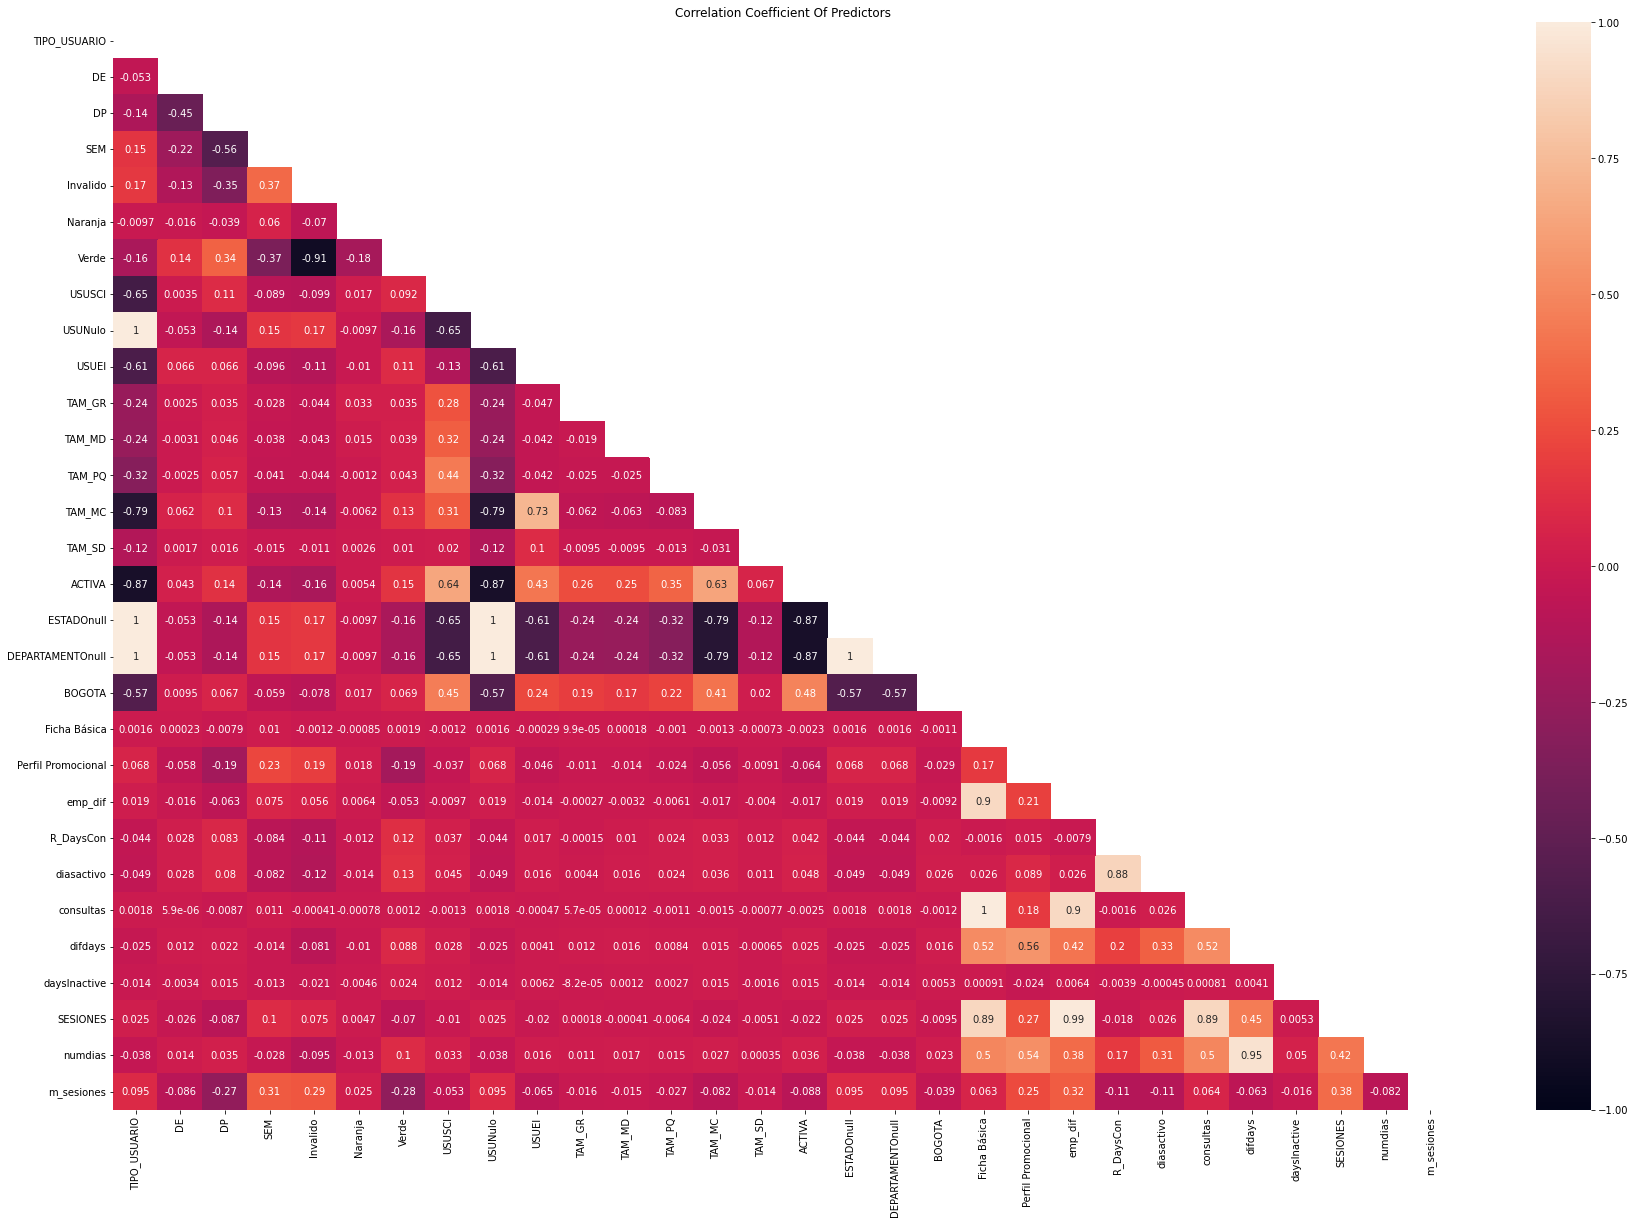

In [ ]:
# Antes de empezar vamos a ver la colinealidad entre las variables
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns

# set figure size
plt.figure(figsize=(30,20))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(X.corr(), dtype=bool))

# generate heatmap
sns.heatmap(X.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

Gracias al heatmap, podemos identificar fuertes relaciones por ejemplo entre:

* emp_dif y Ficha básica
* ACTIVA y UsuNulo
* TAM_MC y TIPO_USUARIO
* SESIONES y consultas

Esto significa que debemos eliminar una de las variables relacionadas? La respuesta es no. La eliminación de variables corre el riesgo de eliminar demasiada información importante. Para saber si eliminarlos o no, vamos a calcular los valores VIF (Factor de Inflación de Varianza).

In [ ]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

/usr/local/lib/python3.8/dist-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [ ]:
vif_data.sort_values(['VIF', 'feature'], ascending=False)

,feature,VIF
24,consultas,inf
8,USUNulo,inf
0,TIPO_USUARIO,inf
20,Perfil Promocional,inf
19,Ficha Básica,inf
16,ESTADOnull,inf
17,DEPARTAMENTOnull,inf
27,SESIONES,58.697733
21,emp_dif,48.515433
13,TAM_MC,23.321930


Como vemos, existen 18 variables que superan el 5. Esto nos podría llevar a pensar en eliminar todas estas variables. Pero esto no es así, se debe ir borrando una a una y calculando los valores VIF a cada paso, ya que al borrar una variable puede darse que eliminemos la colinealidad entre el resto. Así, también, nos aseguramos que la perdida de información es la minima posible.

In [ ]:
# Eliminamos por tanto la variable 'consultas':
X = usuarios3[[ 'TIPO_USUARIO', 'DE', 'DP', 'SEM', 'Invalido', 'Naranja', 'Verde', 'USUSCI',
              'USUNulo', 'USUEI', 'TAM_GR', 'TAM_MD', 'TAM_PQ', 'TAM_MC', 'TAM_SD', 'ACTIVA',
              'ESTADOnull', 'DEPARTAMENTOnull', 'BOGOTA', 'Ficha Básica', 'Perfil Promocional',
              'emp_dif', 'R_DaysCon', 'diasactivo',
              'difdays', 'daysInactive', 'SESIONES', 'numdias', 'm_sesiones']]

In [ ]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

In [ ]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

/usr/local/lib/python3.8/dist-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [ ]:
vif_data.sort_values(['VIF', 'feature'], ascending=False)

,feature,VIF
8,USUNulo,inf
0,TIPO_USUARIO,inf
16,ESTADOnull,inf
17,DEPARTAMENTOnull,inf
26,SESIONES,58.697733
21,emp_dif,48.515433
13,TAM_MC,23.321930
24,difdays,12.198510
27,numdias,11.445156
19,Ficha Básica,9.945060


Continuamos el mismo proceso con USUNulo:

In [ ]:
# Eliminamos por tanto la variable 'USUNulo':
X = usuarios3[[ 'TIPO_USUARIO', 'DE', 'DP', 'SEM', 'Invalido', 'Naranja', 'Verde', 'USUSCI',
              'USUEI', 'TAM_GR', 'TAM_MD', 'TAM_PQ', 'TAM_MC', 'TAM_SD', 'ACTIVA',
              'ESTADOnull', 'DEPARTAMENTOnull', 'BOGOTA', 'Ficha Básica', 'Perfil Promocional',
              'emp_dif', 'R_DaysCon', 'diasactivo',
              'difdays', 'daysInactive', 'SESIONES', 'numdias', 'm_sesiones']]

In [ ]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

In [ ]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

/usr/local/lib/python3.8/dist-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [ ]:
vif_data.sort_values(['VIF', 'feature'], ascending=False)

,feature,VIF
0,TIPO_USUARIO,inf
15,ESTADOnull,inf
16,DEPARTAMENTOnull,inf
25,SESIONES,58.697733
20,emp_dif,48.515433
12,TAM_MC,23.321930
23,difdays,12.198510
26,numdias,11.445156
18,Ficha Básica,9.945060
6,Verde,8.351282


Continuamos el mismo proceso con TIPO_USUARIO:


In [ ]:
# Eliminamos por tanto la variable 'TIPO_USUARIO':
X = usuarios3[['DE', 'DP', 'SEM', 'Invalido', 'Naranja', 'Verde', 'USUSCI',
              'USUEI', 'TAM_GR', 'TAM_MD', 'TAM_PQ', 'TAM_MC', 'TAM_SD', 'ACTIVA',
              'ESTADOnull', 'DEPARTAMENTOnull', 'BOGOTA', 'Ficha Básica', 'Perfil Promocional',
              'emp_dif', 'R_DaysCon', 'diasactivo',
              'difdays', 'daysInactive', 'SESIONES', 'numdias', 'm_sesiones']]

In [ ]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

In [ ]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

/usr/local/lib/python3.8/dist-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [ ]:
vif_data.sort_values(['VIF', 'feature'], ascending=False)

,feature,VIF
14,ESTADOnull,inf
15,DEPARTAMENTOnull,inf
24,SESIONES,58.697733
19,emp_dif,48.515433
11,TAM_MC,23.321930
22,difdays,12.198510
25,numdias,11.445156
17,Ficha Básica,9.945060
5,Verde,8.351282
3,Invalido,8.308309


Continuamos el mismo proceso con ESTADOnull:

In [ ]:
# Eliminamos por tanto la variable 'ESTADOnull':
X = usuarios3[['DE', 'DP', 'SEM', 'Invalido', 'Naranja', 'Verde', 'USUSCI',
              'USUEI', 'TAM_GR', 'TAM_MD', 'TAM_PQ', 'TAM_MC', 'TAM_SD', 'ACTIVA',
              'DEPARTAMENTOnull', 'BOGOTA', 'Ficha Básica', 'Perfil Promocional',
              'emp_dif', 'R_DaysCon', 'diasactivo',
              'difdays', 'daysInactive', 'SESIONES', 'numdias', 'm_sesiones']]

In [ ]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

In [ ]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

In [ ]:
vif_data.sort_values(['VIF', 'feature'], ascending=False)

,feature,VIF
23,SESIONES,58.697733
18,emp_dif,48.515433
14,DEPARTAMENTOnull,39.462891
11,TAM_MC,23.321930
21,difdays,12.198510
24,numdias,11.445156
16,Ficha Básica,9.945060
5,Verde,8.351282
3,Invalido,8.308309
7,USUEI,6.510367


Vemos que ya no existen variables con VIF igual a infinito. Pero, por otro lado, podemos observar que siguen habiendo muchas por encima de 5. Vamos a ir eliminandolas una a una.

In [ ]:
# Eliminamos por tanto la variable 'SESIONES':
X = usuarios3[['DE', 'DP', 'SEM', 'Invalido', 'Naranja', 'Verde', 'USUSCI',
              'USUEI', 'TAM_GR', 'TAM_MD', 'TAM_PQ', 'TAM_MC', 'TAM_SD', 'ACTIVA',
              'DEPARTAMENTOnull', 'BOGOTA', 'Ficha Básica', 'Perfil Promocional',
              'emp_dif', 'R_DaysCon', 'diasactivo',
              'difdays', 'daysInactive', 'numdias', 'm_sesiones']]

In [ ]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

In [ ]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

In [ ]:
vif_data.sort_values(['VIF', 'feature'], ascending=False)

,feature,VIF
14,DEPARTAMENTOnull,39.442489
11,TAM_MC,23.319217
21,difdays,12.018356
23,numdias,11.052683
16,Ficha Básica,8.977151
18,emp_dif,8.817942
5,Verde,8.350117
3,Invalido,8.307901
7,USUEI,6.510367
6,USUSCI,6.434829


Seguimos con DEPARTAMENTOnull:

In [ ]:
# Eliminamos por tanto la variable 'DEPARTAMENTOnull':
X = usuarios3[['DE', 'DP', 'SEM', 'Invalido', 'Naranja', 'Verde', 'USUSCI',
              'USUEI', 'TAM_GR', 'TAM_MD', 'TAM_PQ', 'TAM_MC', 'TAM_SD', 'ACTIVA',
              'BOGOTA', 'Ficha Básica', 'Perfil Promocional',
              'emp_dif', 'R_DaysCon', 'diasactivo',
              'difdays', 'daysInactive', 'numdias', 'm_sesiones']]

In [ ]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

In [ ]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

In [ ]:
vif_data.sort_values(['VIF', 'feature'], ascending=False)

,feature,VIF
20,difdays,32.522566
22,numdias,27.419248
11,TAM_MC,14.708358
17,emp_dif,9.145233
5,Verde,9.133605
15,Ficha Básica,8.961305
6,USUSCI,7.303103
7,USUEI,7.284027
1,DP,6.042787
13,ACTIVA,5.550556


Continuamos con diffdays:

In [ ]:
# Eliminamos por tanto la variable 'diffdays':
X = usuarios3[['DE', 'DP', 'SEM', 'Invalido', 'Naranja', 'Verde', 'USUSCI',
              'USUEI', 'TAM_GR', 'TAM_MD', 'TAM_PQ', 'TAM_MC', 'TAM_SD', 'ACTIVA',
              'BOGOTA', 'Ficha Básica', 'Perfil Promocional',
              'emp_dif', 'R_DaysCon', 'diasactivo',
              'daysInactive', 'numdias', 'm_sesiones']]

In [ ]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

In [ ]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

In [ ]:
vif_data.sort_values(['VIF', 'feature'], ascending=False)

,feature,VIF
11,TAM_MC,14.707922
17,emp_dif,9.116268
15,Ficha Básica,8.948093
5,Verde,8.890061
6,USUSCI,7.302485
7,USUEI,7.284017
21,numdias,6.144525
1,DP,6.019836
13,ACTIVA,5.550482
19,diasactivo,5.201549


Continuamos con TAM_MC:

In [ ]:
# Eliminamos por tanto la variable 'TAM_MC':
X = usuarios3[['DE', 'DP', 'SEM', 'Invalido', 'Naranja', 'Verde', 'USUSCI',
              'USUEI', 'TAM_GR', 'TAM_MD', 'TAM_PQ', 'TAM_SD', 'ACTIVA',
              'BOGOTA', 'Ficha Básica', 'Perfil Promocional',
              'emp_dif', 'R_DaysCon', 'diasactivo',
              'daysInactive', 'numdias', 'm_sesiones']]

In [ ]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

In [ ]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

In [ ]:
vif_data.sort_values(['VIF', 'feature'], ascending=False)

,feature,VIF
16,emp_dif,9.116243
14,Ficha Básica,8.948088
5,Verde,8.888007
20,numdias,6.144406
1,DP,6.011013
18,diasactivo,5.201508
17,R_DaysCon,4.709343
12,ACTIVA,4.087970
6,USUSCI,3.479921
3,Invalido,3.423269


In [ ]:
# Eliminamos por tanto la variable 'emp_dif':
X = usuarios3[['DE', 'DP', 'SEM', 'Invalido', 'Naranja', 'Verde', 'USUSCI',
              'USUEI', 'TAM_GR', 'TAM_MD', 'TAM_PQ', 'TAM_SD', 'ACTIVA',
              'BOGOTA', 'Ficha Básica', 'Perfil Promocional',
              'R_DaysCon', 'diasactivo',
              'daysInactive', 'numdias', 'm_sesiones']]

In [ ]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

In [ ]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

In [ ]:
vif_data.sort_values(['VIF', 'feature'], ascending=False)

,feature,VIF
5,Verde,8.887736
1,DP,6.000836
19,numdias,5.918739
17,diasactivo,5.126424
16,R_DaysCon,4.691912
12,ACTIVA,4.087751
6,USUSCI,3.479915
3,Invalido,3.419927
2,SEM,2.779880
15,Perfil Promocional,2.679378


In [ ]:
# Eliminamos por tanto la variable 'Verde':
X = usuarios3[['DE', 'DP', 'SEM', 'Invalido', 'Naranja', 'USUSCI',
              'USUEI', 'TAM_GR', 'TAM_MD', 'TAM_PQ', 'TAM_SD', 'ACTIVA',
              'BOGOTA', 'Ficha Básica', 'Perfil Promocional',
              'R_DaysCon', 'diasactivo',
              'daysInactive', 'numdias', 'm_sesiones']]

In [ ]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

In [ ]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

In [ ]:
vif_data.sort_values(['VIF', 'feature'], ascending=False)

,feature,VIF
18,numdias,5.307240
16,diasactivo,5.094739
15,R_DaysCon,4.669578
11,ACTIVA,4.086068
5,USUSCI,3.478868
14,Perfil Promocional,2.660779
1,DP,2.565863
6,USUEI,2.245407
19,m_sesiones,2.050001
2,SEM,1.957877


In [ ]:
# Eliminamos por tanto la variable 'numdias':
X = usuarios3[['DE', 'DP', 'SEM', 'Invalido', 'Naranja', 'USUSCI',
              'USUEI', 'TAM_GR', 'TAM_MD', 'TAM_PQ', 'TAM_SD', 'ACTIVA',
              'BOGOTA', 'Ficha Básica', 'Perfil Promocional',
              'R_DaysCon', 'diasactivo',
              'daysInactive', 'm_sesiones']]

In [ ]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

In [ ]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

In [ ]:
vif_data.sort_values(['VIF', 'feature'], ascending=False)

,feature,VIF
16,diasactivo,4.674039
15,R_DaysCon,4.545196
11,ACTIVA,4.085303
5,USUSCI,3.478056
6,USUEI,2.244169
18,m_sesiones,2.020604
2,SEM,1.792007
14,Perfil Promocional,1.692113
3,Invalido,1.640514
1,DP,1.595528


Ahora todas las variables tienen una correlación moderada.

In [ ]:
# Por tanto, procedemos a separar las variables objetivo - descriptivas:

X = usuarios3[['DE', 'DP', 'SEM', 'Invalido', 'Naranja', 'USUSCI',
              'USUEI', 'TAM_GR', 'TAM_MD', 'TAM_PQ', 'TAM_SD', 'ACTIVA',
              'BOGOTA', 'Ficha Básica', 'Perfil Promocional',
              'R_DaysCon', 'diasactivo',
              'daysInactive', 'm_sesiones']]

y = usuarios3['IND_CLIENTE']

In [ ]:
# Dividimos el dataset
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 24)

In [ ]:
# Comprobamos el test 
y_test.value_counts()

0    25746
1      497
Name: IND_CLIENTE, dtype: int64

## DecisionTree

In [ ]:
# DecisionTree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
regressor = DecisionTreeRegressor()

# Entrenamos el modelo
regressor.fit(X_train, y_train)

# Predecimos
y_pred_tree = regressor.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
# Check the model performance
print(classification_report(y_test, y_pred_tree.round()))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     25746
           1       0.42      0.35      0.38       497

    accuracy                           0.98     26243
   macro avg       0.70      0.67      0.68     26243
weighted avg       0.98      0.98      0.98     26243



In [ ]:
# Con el fin de comparar los modelos, obtenemos la curva ROC
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred_tree.round())

0.6683384701903647

In [ ]:
# Revisamos las variables mas importantes
importances_sk = regressor.feature_importances_

In [ ]:
# Creating a dataframe with the feature importance by sklearn
features = X.columns.tolist()
feature_importance_sk = {}
for i, feature in enumerate(features):
    feature_importance_sk[feature] = round(importances_sk[i], 3)

In [ ]:
{k: v for k, v in sorted(feature_importance_sk.items(), key=lambda item: item[1])}

{'TAM_SD': 0.002,
 'Naranja': 0.003,
 'TAM_GR': 0.011,
 'USUEI': 0.013,
 'TAM_MD': 0.013,
 'TAM_PQ': 0.015,
 'DE': 0.016,
 'daysInactive': 0.017,
 'USUSCI': 0.018,
 'Invalido': 0.021,
 'SEM': 0.022,
 'ACTIVA': 0.025,
 'BOGOTA': 0.027,
 'DP': 0.03,
 'diasactivo': 0.062,
 'R_DaysCon': 0.098,
 'Perfil Promocional': 0.114,
 'Ficha Básica': 0.232,
 'm_sesiones': 0.262}

## KNN

In [ ]:
# knn
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
neigh = KNeighborsRegressor()

# Entrenamos el modelo
neigh.fit(X_train, y_train)

# Predecimos
y_pred_knn = neigh.predict(X_test)

In [ ]:
# Check the model performance
print(classification_report(y_test, y_pred_knn.round()))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     25746
           1       0.62      0.18      0.28       497

    accuracy                           0.98     26243
   macro avg       0.80      0.59      0.63     26243
weighted avg       0.98      0.98      0.98     26243



In [ ]:
roc_auc_score(y_test, y_pred_knn.round())

0.5884690962523373

Como podemos ver, el F1-Score es mejor en el árbol de decisión por lo que es mejor modelo.

## RandomForest

In [ ]:
# RandomForest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

# Entrenamos el modelo
rf.fit(X_train, y_train)

# Predecimos
y_pred_rf = rf.predict(X_test)

In [ ]:
# Check the model performance
print(classification_report(y_test, y_pred_rf.round()))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     25746
           1       0.58      0.25      0.35       497

    accuracy                           0.98     26243
   macro avg       0.78      0.62      0.67     26243
weighted avg       0.98      0.98      0.98     26243



In [ ]:
roc_auc_score(y_test, y_pred_rf.round())

0.6229812261278384

En este caso, el f1-score sigue siendo mejor en el DecisionTree, por lo que es mejor este primer modelo. 

In [ ]:
importances_sk = rf.feature_importances_

In [ ]:
# Creating a dataframe with the feature importance by sklearn
features = X.columns.tolist()
feature_importance_sk = {}
for i, feature in enumerate(features):
    feature_importance_sk[feature] = round(importances_sk[i], 3)

In [ ]:
{k: v for k, v in sorted(feature_importance_sk.items(), key=lambda item: item[1])}

{'TAM_SD': 0.002,
 'Naranja': 0.004,
 'TAM_GR': 0.009,
 'USUEI': 0.012,
 'TAM_MD': 0.013,
 'DE': 0.014,
 'TAM_PQ': 0.014,
 'daysInactive': 0.014,
 'ACTIVA': 0.017,
 'Invalido': 0.018,
 'BOGOTA': 0.019,
 'SEM': 0.021,
 'USUSCI': 0.021,
 'DP': 0.022,
 'diasactivo': 0.08,
 'R_DaysCon': 0.091,
 'Perfil Promocional': 0.108,
 'Ficha Básica': 0.194,
 'm_sesiones': 0.326}

## XGBoost

In [ ]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train, y_train)
preds_xgb = clf_xgb.predict(X_test)

In [ ]:
print(classification_report(y_test, preds_xgb))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     25746
           1       0.79      0.15      0.25       497

    accuracy                           0.98     26243
   macro avg       0.89      0.58      0.62     26243
weighted avg       0.98      0.98      0.98     26243



In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds_xgb)

0.5750643064477129

En este caso, si miramos el f1-score, muestra el peor resultado de todos los modelos anteriormente probados.

In [ ]:
importances_sk = clf_xgb.feature_importances_

In [ ]:
# Creating a dataframe with the feature importance by sklearn
features = X.columns.tolist()
feature_importance_sk = {}
for i, feature in enumerate(features):
    feature_importance_sk[feature] = round(importances_sk[i], 3)

In [ ]:
{k: v for k, v in sorted(feature_importance_sk.items(), key=lambda item: item[1])}

{'DE': 0.0,
 'Naranja': 0.0,
 'TAM_SD': 0.0,
 'DP': 0.018,
 'TAM_GR': 0.018,
 'diasactivo': 0.021,
 'TAM_PQ': 0.029,
 'USUEI': 0.033,
 'TAM_MD': 0.043,
 'daysInactive': 0.045,
 'Ficha Básica': 0.052,
 'BOGOTA': 0.055,
 'Perfil Promocional': 0.06,
 'R_DaysCon': 0.069,
 'SEM': 0.082,
 'm_sesiones': 0.087,
 'ACTIVA': 0.127,
 'USUSCI': 0.13,
 'Invalido': 0.131}

## Random Oversampling

In [ ]:
# Random Oversampling for Imbalanced Dataset
# Randomly over sample the minority class
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)
# Check the number of records after over sampling
print(sorted(Counter(y_train_ros).items()))

[(0, 103060), (1, 103060)]


## Random Oversampling DecisionTree

In [ ]:
# Probamos los modelos con estos datos:

# DecisionTree
regressor = DecisionTreeRegressor()

# Entrenamos el modelo
regressor.fit(X_train_ros, y_train_ros)

# Predecimos
y_pred_tree = regressor.predict(X_test)

In [ ]:
# Check the model performance
print(classification_report(y_test, y_pred_tree.round()))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     25746
           1       0.16      0.51      0.25       497

    accuracy                           0.94     26243
   macro avg       0.58      0.73      0.61     26243
weighted avg       0.97      0.94      0.96     26243



In [ ]:
# Con el fin de comparar los modelos, obtenemos la curva ROC
roc_auc_score(y_test, y_pred_tree.round())

0.7295718301106257

Vemos que los resultados no mejoran a los obtenidos sin aplicar ninguna tecnica de balanceo.

In [ ]:
importances_sk = regressor.feature_importances_

In [ ]:
# Creating a dataframe with the feature importance by sklearn
features = X.columns.tolist()
feature_importance_sk = {}
for i, feature in enumerate(features):
    feature_importance_sk[feature] = round(importances_sk[i], 3)

In [ ]:
{k: v for k, v in sorted(feature_importance_sk.items(), key=lambda item: item[1])}

{'TAM_SD': 0.001,
 'Naranja': 0.002,
 'TAM_GR': 0.002,
 'TAM_MD': 0.005,
 'TAM_PQ': 0.006,
 'daysInactive': 0.008,
 'USUEI': 0.009,
 'BOGOTA': 0.01,
 'ACTIVA': 0.011,
 'DE': 0.012,
 'DP': 0.016,
 'SEM': 0.016,
 'diasactivo': 0.022,
 'USUSCI': 0.049,
 'R_DaysCon': 0.092,
 'Ficha Básica': 0.111,
 'Invalido': 0.133,
 'Perfil Promocional': 0.179,
 'm_sesiones': 0.317}

## Random Oversampling KNN

In [ ]:
# knn
neigh = KNeighborsRegressor()

# Entrenamos el modelo
neigh.fit(X_train_ros, y_train_ros)

# Predecimos
y_pred_knn = neigh.predict(X_test)

In [ ]:
# Check the model performance
print(classification_report(y_test, y_pred_knn.round()))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     25746
           1       0.16      0.58      0.26       497

    accuracy                           0.94     26243
   macro avg       0.58      0.76      0.61     26243
weighted avg       0.98      0.94      0.95     26243



In [ ]:
# Con el fin de comparar los modelos, obtenemos la curva ROC
roc_auc_score(y_test, y_pred_knn.round())

0.7630275946051513

En este caso vemos que no funciona mejor que el DecisionTree

## SMOTE Oversampling 

En lugar de sobremuestrear aleatoriamente con reemplazo, SMOTE toma cada muestra minoritaria e introduce puntos de datos sintéticos que conectan la muestra minoritaria y sus vecinos más cercanos. Los vecinos de los k vecinos más cercanos se eligen al azar.

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
# Randomly over sample the minority class
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote= smote.fit_resample(X_train, y_train)
# Check the number of records after over sampling
print(sorted(Counter(y_train_smote).items()))

[(0, 103060), (1, 103060)]


## SMOTE Oversampling DecisionTree

In [ ]:
# Probamos los modelos con estos datos:

# DecisionTree
regressor = DecisionTreeRegressor()

# Entrenamos el modelo
regressor.fit(X_train_smote, y_train_smote)

# Predecimos
y_pred_tree = regressor.predict(X_test)

In [ ]:
# Check the model performance
print(classification_report(y_test, y_pred_tree.round()))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     25746
           1       0.20      0.51      0.29       497

    accuracy                           0.95     26243
   macro avg       0.59      0.74      0.63     26243
weighted avg       0.98      0.95      0.96     26243



In [ ]:
# Con el fin de comparar los modelos, obtenemos la curva ROC
roc_auc_score(y_test, y_pred_tree.round())

0.7366332305961929

Vemos que para este caso no funciona mejor el Decision Tree.

In [ ]:
importances_sk = regressor.feature_importances_

In [ ]:
# Creating a dataframe with the feature importance by sklearn
features = X.columns.tolist()
feature_importance_sk = {}
for i, feature in enumerate(features):
    feature_importance_sk[feature] = round(importances_sk[i], 3)

In [ ]:
{k: v for k, v in sorted(feature_importance_sk.items(), key=lambda item: item[1])}

{'TAM_SD': 0.0,
 'TAM_GR': 0.001,
 'TAM_MD': 0.001,
 'USUSCI': 0.002,
 'TAM_PQ': 0.002,
 'Naranja': 0.003,
 'BOGOTA': 0.003,
 'ACTIVA': 0.006,
 'DE': 0.008,
 'USUEI': 0.008,
 'daysInactive': 0.01,
 'DP': 0.017,
 'SEM': 0.024,
 'R_DaysCon': 0.025,
 'diasactivo': 0.04,
 'Ficha Básica': 0.113,
 'Invalido': 0.18,
 'Perfil Promocional': 0.189,
 'm_sesiones': 0.367}

## SMOTE Oversampling KNN

In [ ]:
# knn
neigh = KNeighborsRegressor()

# Entrenamos el modelo
neigh.fit(X_train_smote, y_train_smote)

# Predecimos
y_pred_knn = neigh.predict(X_test)

In [ ]:
# Check the model performance
print(classification_report(y_test, y_pred_knn.round()))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     25746
           1       0.16      0.63      0.26       497

    accuracy                           0.93     26243
   macro avg       0.58      0.78      0.61     26243
weighted avg       0.98      0.93      0.95     26243



In [ ]:
# Con el fin de comparar los modelos, obtenemos la curva ROC
roc_auc_score(y_test, y_pred_knn.round())

0.7848225842274965

En este caso vemos que los resultados tampoco mejoran.

## Random Under-Sampling

Selecciona y elimina de forma aleatoria datos de la clase mayoritaria. Despues del sampling, la clase mayoritaria debe tener el mismo número de datos que la clase minoritaria.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss
# Randomly under sample the majority class
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus= rus.fit_resample(X_train, y_train)
# Check the number of records after under sampling
print(sorted(Counter(y_train_rus).items()))

[(0, 1908), (1, 1908)]


## Random Under-Sampling DecisionTree

In [ ]:
# Probamos los modelos con estos datos:

# DecisionTree
regressor = DecisionTreeRegressor()

# Entrenamos el modelo
regressor.fit(X_train_rus, y_train_rus)

# Predecimos
y_pred_tree = regressor.predict(X_test)

In [ ]:
# Check the model performance
print(classification_report(y_test, y_pred_tree.round()))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92     25746
           1       0.11      0.86      0.19       497

    accuracy                           0.86     26243
   macro avg       0.55      0.86      0.56     26243
weighted avg       0.98      0.86      0.91     26243



In [ ]:
# Con el fin de comparar los modelos, obtenemos la curva ROC
roc_auc_score(y_test, y_pred_tree.round())

0.8588907014681891

In [ ]:
importances_sk = regressor.feature_importances_

In [ ]:
# Creating a dataframe with the feature importance by sklearn
features = X.columns.tolist()
feature_importance_sk = {}
for i, feature in enumerate(features):
    feature_importance_sk[feature] = round(importances_sk[i], 3)

In [ ]:
{k: v for k, v in sorted(feature_importance_sk.items(), key=lambda item: item[1])}

{'Naranja': 0.002,
 'TAM_GR': 0.002,
 'TAM_SD': 0.002,
 'TAM_PQ': 0.006,
 'daysInactive': 0.006,
 'USUEI': 0.007,
 'TAM_MD': 0.007,
 'DE': 0.008,
 'BOGOTA': 0.013,
 'DP': 0.017,
 'ACTIVA': 0.019,
 'SEM': 0.022,
 'USUSCI': 0.03,
 'diasactivo': 0.03,
 'R_DaysCon': 0.053,
 'Invalido': 0.119,
 'Perfil Promocional': 0.126,
 'Ficha Básica': 0.174,
 'm_sesiones': 0.355}

##Random Under-Sampling KNN

In [ ]:
# knn
neigh = KNeighborsRegressor()

# Entrenamos el modelo
neigh.fit(X_train_rus, y_train_rus)

# Predecimos
y_pred_knn = neigh.predict(X_test)

In [ ]:
# Check the model performance
print(classification_report(y_test, y_pred_knn.round()))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91     25746
           1       0.09      0.85      0.17       497

    accuracy                           0.84     26243
   macro avg       0.54      0.85      0.54     26243
weighted avg       0.98      0.84      0.90     26243



In [ ]:
# Con el fin de comparar los modelos, obtenemos la curva ROC
roc_auc_score(y_test, y_pred_knn.round())

0.8453428564863898

## NearMiss Under-Sampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss
# Under sample the majority class
nearmiss = NearMiss(version=3)
X_train_nearmiss, y_train_nearmiss= nearmiss.fit_resample(X_train, y_train)
# Check the number of records after over sampling
print(sorted(Counter(y_train_nearmiss).items()))

[(0, 1908), (1, 1908)]


## NearMiss Under-Sampling DecisionTree

In [ ]:
# Probamos los modelos con estos datos:

# DecisionTree
regressor = DecisionTreeRegressor()

# Entrenamos el modelo
regressor.fit(X_train_nearmiss, y_train_nearmiss)

# Predecimos
y_pred_tree = regressor.predict(X_test)

In [ ]:
# Check the model performance
print(classification_report(y_test, y_pred_tree.round()))

              precision    recall  f1-score   support

           0       0.98      0.19      0.32     25746
           1       0.02      0.84      0.04       497

    accuracy                           0.21     26243
   macro avg       0.50      0.52      0.18     26243
weighted avg       0.97      0.21      0.32     26243



In [ ]:
# Con el fin de comparar los modelos, obtenemos la curva ROC
roc_auc_score(y_test, y_pred_tree.round())

0.5156523699018473

In [ ]:
importances_sk = regressor.feature_importances_

In [ ]:
# Creating a dataframe with the feature importance by sklearn
features = X.columns.tolist()
feature_importance_sk = {}
for i, feature in enumerate(features):
    feature_importance_sk[feature] = round(importances_sk[i], 3)

In [ ]:
{k: v for k, v in sorted(feature_importance_sk.items(), key=lambda item: item[1])}

{'TAM_SD': 0.0,
 'Naranja': 0.001,
 'TAM_GR': 0.004,
 'DE': 0.007,
 'USUEI': 0.007,
 'TAM_PQ': 0.007,
 'ACTIVA': 0.008,
 'TAM_MD': 0.01,
 'daysInactive': 0.011,
 'BOGOTA': 0.014,
 'SEM': 0.015,
 'DP': 0.017,
 'Invalido': 0.028,
 'USUSCI': 0.04,
 'Perfil Promocional': 0.071,
 'diasactivo': 0.071,
 'm_sesiones': 0.192,
 'Ficha Básica': 0.195,
 'R_DaysCon': 0.3}

## NearMiss Under-Sampling KNN

In [ ]:
# knn
neigh = KNeighborsRegressor()

# Entrenamos el modelo
neigh.fit(X_train_nearmiss, y_train_nearmiss)

# Predecimos
y_pred_knn = neigh.predict(X_test)

In [ ]:
# Check the model performance
print(classification_report(y_test, y_pred_knn.round()))

              precision    recall  f1-score   support

           0       0.97      0.21      0.34     25746
           1       0.02      0.67      0.03       497

    accuracy                           0.22     26243
   macro avg       0.49      0.44      0.19     26243
weighted avg       0.95      0.22      0.34     26243



In [ ]:
# Con el fin de comparar los modelos, obtenemos la curva ROC
roc_auc_score(y_test, y_pred_knn.round())

0.43923984362947666

## PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Estandarizamos
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

pca_test = PCA(n_components = 19)
pca_test.fit(X_train_scaled)

evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(20))

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.150998,0.150998
1,0.259818,0.108820
2,0.354031,0.094213
3,0.427493,0.073463
4,0.492673,0.065180
5,0.549529,0.056856
6,0.604892,0.055363
7,0.658610,0.053718
8,0.711206,0.052596
9,0.763761,0.052555


In [ ]:
# Cogemos 12 componentes ya que explicamos con ellos casi el 90% de la varianza
pca = PCA(n_components=12)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled_pca, y_train)
display(rfc.score(X_train_scaled_pca, y_train))

0.9955224449355994

In [ ]:
y_pred_pca = rfc.predict(X_test_scaled_pca)

In [ ]:
# Check the model performance
print(classification_report(y_test, y_pred_pca.round()))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     25746
           1       0.40      0.05      0.09       497

    accuracy                           0.98     26243
   macro avg       0.69      0.52      0.54     26243
weighted avg       0.97      0.98      0.97     26243



In [ ]:
# Con el fin de comparar los modelos, obtenemos la curva ROC
roc_auc_score(y_test, y_pred_pca.round())

0.5244323472099591

Los resultados no son buenos, por lo que se decide no utilizar un PCA.

## CONCLUSIONES MODELOS SUPERVISADOS

Por tanto, vemos que sin aplicar ninguna técnica de balanceo obtenemos los siguientes resuntados:

*   Decision Tree. Un AUC de 0.66 y un F1 de 0.38.
*   KNN. Un AUC de 0.59 y un F1 de 0.28.
*   Random Forest. Un AUC de 0.62 y un F1 de 0.35.
*   XGBoost. Un AUC de 0.58 y un F1 de 0.25.

Por tanto, vemos que los mejores resultados si observamos el F1-score, los obtiene el Decision Tree, frente al XGBoost, que obtiene los peores resultados. Por tanto, para este caso, vemos que se ajusta mejor un modelo más simple, por lo que seguimos con el Decision Tree y KNN para técnicas de balanceo. Además, si observamos también el AUC, vemos que llegamos a la misma conclusión.

Por otro lado, si realizamos técnicas de Oversampling obtenemos los siguientes resultados:

*   Decision Tree Random Oversampling. Un AUC de 0.73 y un F1 de 0.25.
*   KNN Random Oversampling. Un AUC de 0.76 y un F1 de 0.26.
*   Decision Tree SMOTE Oversampling. Un AUC de 0.74 y un F1 de 0.29.
*   KNN SMOTE Oversampling. Un AUC de 0.78 y un F1 de 0.26.

Por tanto, si observamos el F1-score, vemos que los mejores resultados se obtienen cuando al Decision Tree se le aplica una técnica de SMOTE Oversampling.
Por el contrario, si nos fijamos en el AUC, los mejores resultados se obtienen al aplicar la misma tecnica de Oversampling al modelo KNN. Pero, finalmente, decidimos que el mejor modelo al aplicar las técnicas de Oversampling es el de Decision Tree con SMOTE, ya que al tener un dataset tan desbalanceado, consideramos que se ajusta mejor.

Si comparamos este modelo, con el Decision Tree sin aplicar ninguna técnica de balanceo. Vemos que obteníamos mejores resultados antes. Por lo que concluimos que las tecnicas de Oversampling no nos han ayudado a mejorar nuestros resultados.

Por otro lado, si realizamos técnicas de Undersampling obtenemos los siguientes resultados:

*   Decision Tree Random Undersampling. Un AUC de 0.86 y un F1 de 0.19.
*   KNN Random Undersampling. Un AUC de 0.85 y un F1 de 0.17.
*   Decision Tree NearMiss Undersampling. Un AUC de 0.52 y un F1 de 0.04.
*   KNN NearMiss Undersampling. Un AUC de 0.44 y un F1 de 0.03.

Por tanto, si observamos tanto el F1-score como el AUC, vemos que los mejores resultados se obtienen cuando al Decision Tree se le aplica una técnica de Random Undersampling.

Si comparamos este modelo, con el Decision Tree sin aplicar ninguna técnica de balanceo. Vemos que obteníamos mejores resultados antes. Por lo que concluimos que las tecnicas de Undersampling tampoco nos han ayudado a mejorar nuestros resultados.




# Modelo de aprendizaje NO SUPERVISADO

In [ ]:
# Por tanto, procedemos a separar las variables objetivo - descriptivas:

X = usuarios3[['DE', 'DP', 'SEM', 'Invalido', 'Naranja', 'USUSCI',
              'USUEI', 'TAM_GR', 'TAM_MD', 'TAM_PQ', 'TAM_SD', 'ACTIVA',
              'BOGOTA', 'Ficha Básica', 'Perfil Promocional',
              'R_DaysCon', 'diasactivo',
              'daysInactive', 'm_sesiones']]

y = usuarios3['IND_CLIENTE']

In [ ]:
# Estandarizamos los datos:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

## K-means

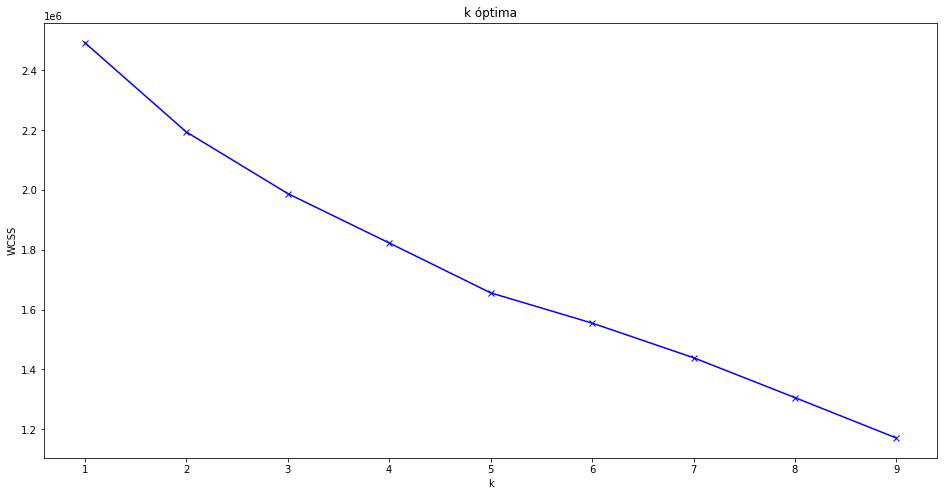

In [ ]:
# Importamos el algoritmo k-means
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# Guardamos en WCSS la suma de cuadrados total dentro del cluster
WCSS = []
# Establecemos un rango de k de 1 a 10 para probar
K = range(1,10)
# Realizamos un bucle y guardamos los resultados de cada iteraccion
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    WCSS.append(kmeanModel.inertia_)
# Representamos graficamente los resultados
plt.figure(figsize=(16,8))
plt.plot(K, WCSS, 'bx-')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('k óptima')
plt.show()

Podemos ver que la k optima no está muy clara con el método del codo, vamos a probar otra técnica: The silhoouette value. El cual mide que tan similar es un punto a su propio grupo (cohesión) en comparación con otros grupos (separación).

In [ ]:
from sklearn.metrics import silhouette_score
k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
score=[]
for n_cluster in k:
    kmeans = KMeans(n_clusters=n_cluster).fit(X)
    silhouette_avg = silhouette_score(X,kmeans.labels_)
    score.append(silhouette_score(X,kmeans.labels_))
    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))

Silhouette Score for 2 Clusters: 0.4129
Silhouette Score for 3 Clusters: 0.2622
Silhouette Score for 4 Clusters: 0.2952
Silhouette Score for 5 Clusters: 0.3470
Silhouette Score for 6 Clusters: 0.3732
Silhouette Score for 7 Clusters: 0.3911
Silhouette Score for 8 Clusters: 0.4066
Silhouette Score for 9 Clusters: 0.3957
Silhouette Score for 10 Clusters: 0.4388


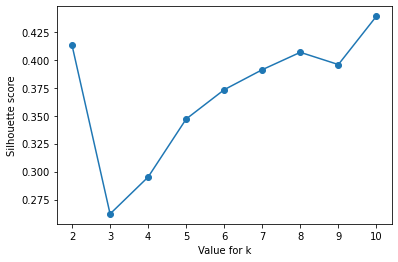

In [ ]:
plt.plot(k, score, 'o-')
plt.xlabel("Value for k")
plt.ylabel("Silhouette score")
plt.show()

Podemos ver en la gráfica que k debería ser 10. Aun así, elegimos k=5 ya que si elegimos una k demasiado grande, será dificil de explicar los clusters. Además, si contemplamos la gráfica podemos observar que a partir del 5 la pendiente se calma y la mejora no es tan notoria.

In [ ]:
from sklearn.cluster import KMeans
# Ahora ejecutaremos el algoritmo, en nuestro caso para 8 clusters
kmeans = KMeans(n_clusters=5).fit(X)
centroids = kmeans.cluster_centers_

In [ ]:
# Guardamos los resultados en una nueva variable del dataframe
usuarios3['Cluster'] = kmeans.labels_

In [ ]:
# Vamos a ver cuantos registros hay por cada cluster:
print(len(usuarios3[usuarios3['Cluster']==0]))
print(len(usuarios3[usuarios3['Cluster']==1]))
print(len(usuarios3[usuarios3['Cluster']==2]))
print(len(usuarios3[usuarios3['Cluster']==3]))
print(len(usuarios3[usuarios3['Cluster']==4]))

60921
14732
34321
3973
17264


Vemos que los usuarios se reparten como:


*   46.43% en el cluster 0
*   11.23% en el cluster 1
*   26.16% en el cluster 2
*   3.03% en el cluster 3
*   13.16% en el cluster 4



In [ ]:
# Vemos cuantos clientes tenemos
len(usuarios3[usuarios3['IND_CLIENTE']==1])

2405

In [ ]:
# Vamos a analizar como son cada cluster:
# Primero observaremos para los diferentes clusters como se comporta respecto a la variable objetivo:
usuarios3[usuarios3['Cluster']==0].IND_CLIENTE.value_counts()

0    60104
1      817
Name: IND_CLIENTE, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==1].IND_CLIENTE.value_counts()

0    13801
1      931
Name: IND_CLIENTE, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==2].IND_CLIENTE.value_counts()

0    34035
1      286
Name: IND_CLIENTE, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==3].IND_CLIENTE.value_counts()

0    3810
1     163
Name: IND_CLIENTE, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==4].IND_CLIENTE.value_counts()

0    17056
1      208
Name: IND_CLIENTE, dtype: int64

La proporción de clientes en la distribución original es de 1.83%. Vemos que hay clusters como el 1 y 3 que tienen una representatividad mayor de clientes con un 6.32%, y 4.1%, respectivamente. En cambio, el cluster 2 vemos que la proporción es bastante más baja con un 0.83%.

In [ ]:
# Seguimos observando la variable DE:
# Primero vamos a mirar cuantos 1 tenemos en total de 131211
len(usuarios3[usuarios3['DE']==1])

19580

In [ ]:
usuarios3[usuarios3['Cluster']==0].DE.value_counts()

0.0    60921
Name: DE, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==1].DE.value_counts()

0.0    13141
1.0     1591
Name: DE, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==2].DE.value_counts()

0.0    34288
1.0       33
Name: DE, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==3].DE.value_counts()

0.0    3281
1.0     692
Name: DE, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==4].DE.value_counts()

1.0    17264
Name: DE, dtype: int64

Esta variable recoge si el canal de registro ha sido mediante directorios especializados, la proporción de usuarios que se registran asi en la distribución original es de 14.92%. Vemos que hay clusters como el 3 y 4 que tienen una representatividad mayor de usuarios que utilizan este canal con un 17.42% y 100%, respectivamente. En cambio, el resto de clusters, es decir, los cluster 0, 1 y 2 vemos que la proporción es más baja con un 0%, 10.8% y 0.1%, respectivamente.

Por tanto, vemos que mientras en el cluster 4, todos son usuarios que realizan el registro mediante utilizando este canal, el cluster 0, no lo hace ninguno. 

In [ ]:
# Seguimos observando la variable DP:
# Primero vamos a mirar cuantos 1 tenemos en total de 131211
len(usuarios3[usuarios3['DP']==1])

70763

In [ ]:
usuarios3[usuarios3['Cluster']==0].DP.value_counts()

1.0    56731
0.0     4190
Name: DP, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==1].DP.value_counts()

1.0    10754
0.0     3978
Name: DP, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==2].DP.value_counts()

0.0    34049
1.0      272
Name: DP, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==3].DP.value_counts()

1.0    3006
0.0     967
Name: DP, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==4].DP.value_counts()

0.0    17264
Name: DP, dtype: int64

Esta variable recoge si el canal de registro ha sido mediante directorios populares, la proporción de usuarios que se registran asi en la distribución original es de 53.93%. Vemos que hay en todos los clusters, salvo en el 2 y 4, proporcionalmente hay más usuarios que se registran utilizando este método. Mientras que en el cluster 4 no lo hace ninguno y en el cluster 2 solo el 0.79%.

In [ ]:
# Seguimos observando la variable SEM:
# Primero vamos a mirar cuantos 1 tenemos en total de 131211
len(usuarios3[usuarios3['SEM']==1])

27858

In [ ]:
usuarios3[usuarios3['Cluster']==0].SEM.value_counts()

0.0    60917
1.0        4
Name: SEM, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==1].SEM.value_counts()

0.0    13151
1.0     1581
Name: SEM, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==2].SEM.value_counts()

1.0    26086
0.0     8235
Name: SEM, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==3].SEM.value_counts()

0.0    3786
1.0     187
Name: SEM, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==4].SEM.value_counts()

0.0    17264
Name: SEM, dtype: int64

Esta variable recoge si el canal de registro ha sido mediante SEM, la proporción de usuarios que se registran asi en la distribución original es de 21.23%. Vemos que solo el cluster 2 es mayor, en proporción comparado con la distribución original, tenemos un 76% de los clientes que se registran mediante SEM. El resto de clusters, lo hace en una proporción menor, siendo en el cluster 0 y 4, el 0% de los usuarios.

In [ ]:
# Seguimos observando la variable Invalido:
# Primero vamos a mirar cuantos 1 tenemos en total de 131211
len(usuarios3[usuarios3['Invalido']==1])

34578

In [ ]:
usuarios3[usuarios3['Cluster']==0].Invalido.value_counts()

0.0    53859
1.0     7062
Name: Invalido, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==1].Invalido.value_counts()

0.0    12702
1.0     2030
Name: Invalido, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==2].Invalido.value_counts()

1.0    23109
0.0    11212
Name: Invalido, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==3].Invalido.value_counts()

0.0    3893
1.0      80
Name: Invalido, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==4].Invalido.value_counts()

0.0    14967
1.0     2297
Name: Invalido, dtype: int64

Esta variable recoge si el email es SPAM, Rojo o tiene un dominio inválido, la proporción de usuarios con este tipo de email en la distribución original es de 26.35%. Vemos que tan solo el cluster 2 es mayor, en proporción comparado con la distribución original, tenemos un 67.33% de los clientes que tienen un email Invalido. El resto de clusters, lo hace en una proporción menor.

In [ ]:
# Seguimos observando la variable Naranja:
# Primero vamos a mirar cuantos 1 tenemos en total de 131211
len(usuarios3[usuarios3['Naranja']==1])

1756

In [ ]:
usuarios3[usuarios3['Cluster']==0].Naranja.value_counts()

0.0    60380
1.0      541
Name: Naranja, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==1].Naranja.value_counts()

0.0    14434
1.0      298
Name: Naranja, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==2].Naranja.value_counts()

0.0    33547
1.0      774
Name: Naranja, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==3].Naranja.value_counts()

0.0    3954
1.0      19
Name: Naranja, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==4].Naranja.value_counts()

0.0    17140
1.0      124
Name: Naranja, dtype: int64

Esta variable recoge si el email ha dado un error temporal pero se sigue enviando, la proporción de usuarios con este tipo de email en la distribución original es de 1.34%. Vemos que tan solo los clusters 1 y 2 son mayores en proporción, comparado con la distribución original, tenemos un 2.02% y un 2.26% de los clientes que tienen un email Naranja, respectivamente. El resto de clusters, lo hace en una proporción menor.

In [ ]:
# Seguimos observando la variable USUSCI:
# Primero vamos a mirar cuantos 1 tenemos en total de 131211
len(usuarios3[usuarios3['USUSCI']==1])

15600

In [ ]:
usuarios3[usuarios3['Cluster']==0].USUSCI.value_counts()

0    60584
1      337
Name: USUSCI, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==1].USUSCI.value_counts()

1    13588
0     1144
Name: USUSCI, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==2].USUSCI.value_counts()

0    34037
1      284
Name: USUSCI, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==3].USUSCI.value_counts()

0    3370
1     603
Name: USUSCI, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==4].USUSCI.value_counts()

0    16476
1      788
Name: USUSCI, dtype: int64

Esta variable recoge si el usuario es una sociedad comercial/industrial, la proporción de usuarios en la distribución original es de 11.89%. Vemos que tan solo los clusters 1 y 3 son mayores en proporción, comparado con la distribución original, tenemos un 7.77% y un 15.18% de los usuarios que son una sociedad comercial/industrial, respectivamente. El resto de clusters, lo hace en una proporción menor.

In [ ]:
# Seguimos observando la variable USUEI:
# Primero vamos a mirar cuantos 1 tenemos en total de 131211
len(usuarios3[usuarios3['USUEI']==1])

13937

In [ ]:
usuarios3[usuarios3['Cluster']==0].USUEI.value_counts()

0    52077
1     8844
Name: USUEI, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==1].USUEI.value_counts()

0    14590
1      142
Name: USUEI, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==2].USUEI.value_counts()

0    32836
1     1485
Name: USUEI, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==3].USUEI.value_counts()

0    3416
1     557
Name: USUEI, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==4].USUEI.value_counts()

0    14355
1     2909
Name: USUEI, dtype: int64

Esta variable recoge si el usuario es un empresario individual, la proporción de usuarios en la distribución original es de 10.62%. Vemos que los clusters 0, 3 y 4 son mayores en proporción, comparado con la distribución original, tenemos un 14.52%, 14.02% y un 16.85% de los usuarios que son empresarios individuales, respectivamente. El resto de clusters, lo hace en una proporción menor.

In [ ]:
# Seguimos observando la variable TAM_GR:
# Primero vamos a mirar cuantos 1 tenemos en total de 131211
len(usuarios3[usuarios3['TAM_GR']==1])

2433

In [ ]:
usuarios3[usuarios3['Cluster']==0].TAM_GR.value_counts()

0    60909
1       12
Name: TAM_GR, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==1].TAM_GR.value_counts()

0    12415
1     2317
Name: TAM_GR, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==2].TAM_GR.value_counts()

0    34311
1       10
Name: TAM_GR, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==3].TAM_GR.value_counts()

0    3912
1      61
Name: TAM_GR, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==4].TAM_GR.value_counts()

0    17231
1       33
Name: TAM_GR, dtype: int64

Esta variable recoge si la empresa es grande, la proporción de usuarios en la distribución original es de 1.85%. Vemos que tan solo el cluster 1 es mayor en proporción, comparado con la distribución original, tenemos un 15.73% de los usuarios que son empresas grandes. El resto de clusters, lo hace en una proporción menor, destacando que los clusters 0 y 2 son próximos al 0%.

In [ ]:
# Seguimos observando la variable TAM_MD:
# Primero vamos a mirar cuantos 1 tenemos en total de 131211
len(usuarios3[usuarios3['TAM_MD']==1])

2471

In [ ]:
usuarios3[usuarios3['Cluster']==0].TAM_MD.value_counts()

0    60905
1       16
Name: TAM_MD, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==1].TAM_MD.value_counts()

0    12378
1     2354
Name: TAM_MD, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==2].TAM_MD.value_counts()

0    34316
1        5
Name: TAM_MD, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==3].TAM_MD.value_counts()

0    3904
1      69
Name: TAM_MD, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==4].TAM_MD.value_counts()

0    17237
1       27
Name: TAM_MD, dtype: int64

Esta variable recoge si la empresa es mediana, la proporción de usuarios en la distribución original es de 1.88%. Vemos que tan solo el cluster 1 es mayor en proporción, comparado con la distribución original, tenemos un 15.98% de los usuarios que son empresas medianas. El resto de clusters, lo hace en una proporción menor, destacando que los clusters 0 y 2 son próximos al 0%.

In [ ]:
# Seguimos observando la variable TAM_PQ:
# Primero vamos a mirar cuantos 1 tenemos en total de 131211
len(usuarios3[usuarios3['TAM_PQ']==1])

4279

In [ ]:
usuarios3[usuarios3['Cluster']==0].TAM_PQ.value_counts()

0    60908
1       13
Name: TAM_PQ, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==1].TAM_PQ.value_counts()

0    10666
1     4066
Name: TAM_PQ, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==2].TAM_PQ.value_counts()

0    34307
1       14
Name: TAM_PQ, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==3].TAM_PQ.value_counts()

0    3820
1     153
Name: TAM_PQ, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==4].TAM_PQ.value_counts()

0    17231
1       33
Name: TAM_PQ, dtype: int64

Esta variable recoge si la empresa es pequeña, la proporción de usuarios en la distribución original es de 3.26%. Vemos que tan solo el cluster 1 es mayor en proporción, comparado con la distribución original, tenemos un 27.6% de los usuarios que son empresas pequeñas. El resto de clusters, lo hace en una proporción menor, destacando que los clusters 0 y 2 son próximos al 0%.

In [ ]:
# Seguimos observando la variable TAM_SD:
# Primero vamos a mirar cuantos 1 tenemos en total de 131211
len(usuarios3[usuarios3['TAM_SD']==1])

620

In [ ]:
usuarios3[usuarios3['Cluster']==0].TAM_SD.value_counts()

0    60587
1      334
Name: TAM_SD, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==1].TAM_SD.value_counts()

0    14653
1       79
Name: TAM_SD, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==2].TAM_SD.value_counts()

0    34241
1       80
Name: TAM_SD, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==3].TAM_SD.value_counts()

0    3937
1      36
Name: TAM_SD, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==4].TAM_SD.value_counts()

0    17173
1       91
Name: TAM_SD, dtype: int64

Esta variable recoge si el tipo de empresa está sin definir, la proporción de usuarios en la distribución original es de 0.47%. Vemos que tan solo el cluster 2 es menor en proporción, comparado con la distribución original, tenemos un 0.23% de los usuarios. El resto de clusters, lo hace en una proporción mayor.

In [ ]:
# Seguimos observando la variable ACTIVA:
# Primero vamos a mirar cuantos 1 tenemos en total de 131211
len(usuarios3[usuarios3['ACTIVA']==1])

25759

In [ ]:
usuarios3[usuarios3['Cluster']==0].ACTIVA.value_counts()

0    53928
1     6993
Name: ACTIVA, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==1].ACTIVA.value_counts()

1    13755
0      977
Name: ACTIVA, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==2].ACTIVA.value_counts()

0    33268
1     1053
Name: ACTIVA, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==3].ACTIVA.value_counts()

0    2956
1    1017
Name: ACTIVA, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==4].ACTIVA.value_counts()

0    14323
1     2941
Name: ACTIVA, dtype: int64

Esta variable recoge si la situación de la compañía es o no ACTIVA, la proporción de empresas activas en la distribución original es de 19.63%. Vemos que los clusters 1 y 3 son mayores en proporción, comparado con la distribución original, con un 93.37% y un 26.6% de los usuarios, respectivamente. El resto de clusters, lo hace en una proporción menor. Destacar, por tanto, que en el cluster 1, casi todos los usuaios son compañías activas.

In [ ]:
# Seguimos observando la variable BOGOTA:
# Primero vamos a mirar cuantos 1 tenemos en total de 131211
len(usuarios3[usuarios3['BOGOTA']==1])

12376

In [ ]:
usuarios3[usuarios3['Cluster']==0].BOGOTA.value_counts()

0    58046
1     2875
Name: BOGOTA, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==1].BOGOTA.value_counts()

0    7409
1    7323
Name: BOGOTA, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==2].BOGOTA.value_counts()

0    33483
1      838
Name: BOGOTA, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==3].BOGOTA.value_counts()

0    3546
1     427
Name: BOGOTA, dtype: int64

In [ ]:
usuarios3[usuarios3['Cluster']==4].BOGOTA.value_counts()

0    16351
1      913
Name: BOGOTA, dtype: int64

Esta variable recoge si la sede o departamento del usuario está en Bogotá, la proporción de usuarios en la distribución original es de 9.43%. Vemos que los clusters 1 y 3 son mayores en proporción, comparado con la distribución original, con un 49.71% y un 10.75% de los usuarios, respectivamente. El resto de clusters, lo hace en una proporción menor.

In [ ]:
# Seguimos observando la variable Ficha Básica:
df0 = usuarios3[usuarios3['Cluster']==0]
df1 = usuarios3[usuarios3['Cluster']==1]
df2 = usuarios3[usuarios3['Cluster']==2]
df3 = usuarios3[usuarios3['Cluster']==3]
df4 = usuarios3[usuarios3['Cluster']==4]

In [ ]:
dicc = {}
dicc["Cluster0"] = df0['Ficha Básica']
dicc["Cluster1"] = df1['Ficha Básica']
dicc["Cluster2"] = df2['Ficha Básica']
dicc["Cluster3"] = df3['Ficha Básica']
dicc["Cluster4"] = df4['Ficha Básica']

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


(-10.0, 30.0)

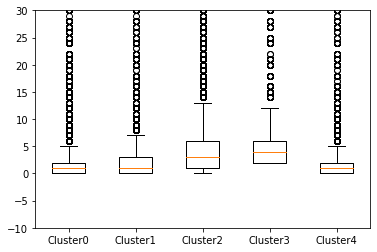

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(dicc.values())
ax.set_xticklabels(dicc.keys())
ax.set_ylim([-10, 30]) # Acotamos la visualización para poder ver el box-plot mejor

Esta variable recoge cuantas veces cada usuario consume el producto "ficha básica". En el plot podemos visualizar que los clusters 0, 1 y 4 consumen menos en media y que los clusters 2 y 3 lo hacen más. Además, remarcar que el cluster 2 es el que tiene outliers más altos.

In [ ]:
# Seguimos con la variable Perfil promocional
dicc = {}
dicc["Cluster0"] = df0['Perfil Promocional']
dicc["Cluster1"] = df1['Perfil Promocional']
dicc["Cluster2"] = df2['Perfil Promocional']
dicc["Cluster3"] = df3['Perfil Promocional']
dicc["Cluster4"] = df4['Perfil Promocional']

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


(-5.0, 20.0)

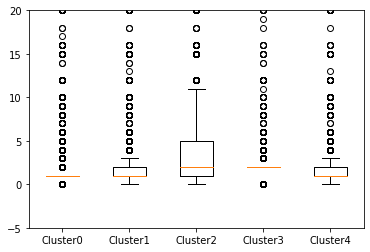

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(dicc.values())
ax.set_xticklabels(dicc.keys())
ax.set_ylim([-5, 20]) # Acotamos la visualización para poder ver el box-plot mejor

Esta variable recoge cuantas veces cada usuario consume el producto "perfil promocional". En el plot podemos visualizar que los clusters 0, 1 y 4 consumen menos en media y que los clusters 2 y 3 lo hacen más. Además, remarcar que el cluster 2 es el que tiene outliers más altos.

In [ ]:
# Seguimos con la variable R_DaysCon
dicc = {}
dicc["Cluster0"] = df0['R_DaysCon']
dicc["Cluster1"] = df1['R_DaysCon']
dicc["Cluster2"] = df2['R_DaysCon']
dicc["Cluster3"] = df3['R_DaysCon']
dicc["Cluster4"] = df4['R_DaysCon']

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


(-5.0, 200.0)

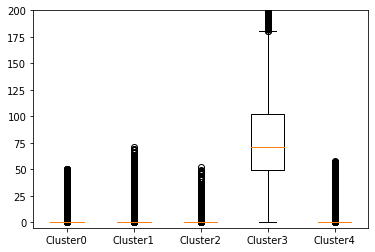

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(dicc.values())
ax.set_xticklabels(dicc.keys())
ax.set_ylim([-5, 200]) # Acotamos la visualización para poder ver el box-plot mejor

Esta variable recoge la diferencia entre la primera y última consulta entre el número total de consultas por usuarios. Como podemos ver, cuanto más grande este ratio, más probabilidad de que esté en el cluster 3.

In [ ]:
# Seguimos con la variable diasactivo
dicc = {}
dicc["Cluster0"] = df0['diasactivo']
dicc["Cluster1"] = df1['diasactivo']
dicc["Cluster2"] = df2['diasactivo']
dicc["Cluster3"] = df3['diasactivo']
dicc["Cluster4"] = df4['diasactivo']

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


[Text(0, 0, 'Cluster0'),
 Text(0, 0, 'Cluster1'),
 Text(0, 0, 'Cluster2'),
 Text(0, 0, 'Cluster3'),
 Text(0, 0, 'Cluster4')]

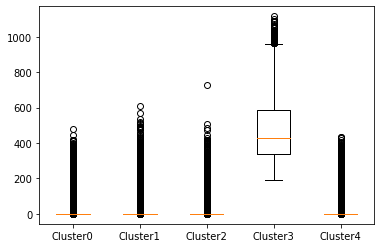

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(dicc.values())
ax.set_xticklabels(dicc.keys())

Esta variable recoge la diferencia entre la primera y última consulta. Como podemos ver, como en el caso anterior, cuanto más grande este ratio, más probabilidad de que esté en el cluster 3.

In [ ]:
# Seguimos con la variable daysInactive
dicc = {}
dicc["Cluster0"] = df0['daysInactive']
dicc["Cluster1"] = df1['daysInactive']
dicc["Cluster2"] = df2['daysInactive']
dicc["Cluster3"] = df3['daysInactive']
dicc["Cluster4"] = df4['daysInactive']

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


(-5.0, 10.0)

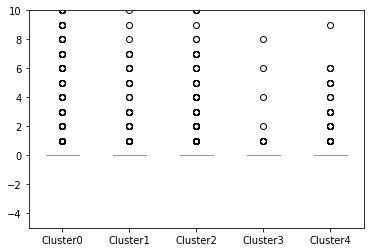

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(dicc.values())
ax.set_xticklabels(dicc.keys())
ax.set_ylim([-5, 10]) # Acotamos la visualización para poder ver el box-plot mejor

In [ ]:
df0['daysInactive'].describe()

count    60921.000000
mean         0.876167
std         19.054792
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1048.000000
Name: daysInactive, dtype: float64

In [ ]:
df1['daysInactive'].describe()

count    14732.000000
mean         1.227668
std         22.998293
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        965.000000
Name: daysInactive, dtype: float64

In [ ]:
df2['daysInactive'].describe()

count    34321.000000
mean         0.083855
std          4.598332
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        618.000000
Name: daysInactive, dtype: float64

In [ ]:
df3['daysInactive'].describe()

count    3973.000000
mean        0.453310
std         9.780015
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       399.000000
Name: daysInactive, dtype: float64

In [ ]:
df4['daysInactive'].describe()

count    17264.000000
mean         0.442018
std         12.756989
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        753.000000
Name: daysInactive, dtype: float64

Esta variable recoge la diferencia entre la fecha de registro y la primera consulta. Como podemos ver, el box-plot no nos ayuda mucho a definir los clusters. Cuando utilizamos la función describe vemos que el cluster 1 tiene la media más grande frente al cluster 2 que tiene la media más pequeña.

In [ ]:
# Seguimos con la variable m_sesiones
dicc = {}
dicc["Cluster0"] = df0['m_sesiones']
dicc["Cluster1"] = df1['m_sesiones']
dicc["Cluster2"] = df2['m_sesiones']
dicc["Cluster3"] = df3['m_sesiones']
dicc["Cluster4"] = df4['m_sesiones']

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


(-5.0, 50.0)

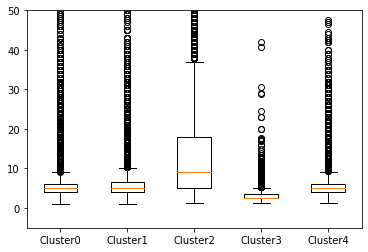

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(dicc.values())
ax.set_xticklabels(dicc.keys())
ax.set_ylim([-5, 50]) # Acotamos la visualización para poder ver el box-plot mejor

Esta variable recoge la media de sesiones diarias por usuario. En el plot podemos visualizar que el cluster 3 consume menos en media y que el cluster 2 lo hace más. 

## CONCLUSIONES MODELO NO SUPERVISADO K-MEANS

Por tanto, podemos decir que:


*   El cluster 0
      - El registro NO lo hacen mediante directorios especializados, ni a través de SEM.
      - Son personas físicas.
      - Son usuarios con un alto interés ya que cuando se registran hacen rapidamente la primera consulta.
*   El cluster 1
      - Proporcionalmente, es el cluster con mayor número de clientes.
      - Más del 25% son empresas pequeñas.
      - La mitad son empresas activas.
      - Pasan más días sin hacer su primera consulta desde el registro.
*   El cluster 2.
      - No hay clientes
      - El registro NO lo hacen mediante directorios especializados, ni directorios populares. Sino que mayoritariamente lo hacen a traves de SEM.
      - Mayoritariamente tienen un email invalido.
      - Son personas físicas.
      - Consultan más los productos.
      - Son los que más sesiones diarias hacen.
*   El cluster 3
      - Consultan más los productos.
      - Pasan muchos días entre la primera y última consulta, por lo que tardan más en hacerse clientes.
      - Son los que menos sesiones diarias hacen.
*   El cluster 4
      - El registro lo hacen mediante directorios especializados.
      - Guarda el mayor porcentaje, en proporción, de empresarios individuales.

Por tanto, el cluster menos recomendado es el 2, ya que son usuarios que consumen muchos productos pero no terminan haciendose clientes. Por el contrario, vemos que el cluster 1 es el más interesante, ya que es el que más clientes guarda, proporcionalmente. Al no realizar la consulta inmediatamente despues de la fecha de registro, muestra que son clientes que saben que la empresa les puede ayudar a conseguir los documetos que requieran.



## DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
clusters = DBSCAN(eps=2.5, min_samples=5).fit(X)

# Guardamos los resultados en una nueva variable del dataframe
usuarios3['ClusterDBSCAN'] = clusters.labels_

No podemos ejecutar este algoritmo ya que consume toda la RAM.